Use the `requirements.txt` file to load the necessary libraries into your virtual environment with the following command:

```bash
pip install -r requirements.txt
```

# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
from tqdm import trange
import time

from sklearn.neural_network import MLPClassifier

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2

# 1. MLP Implementations

## 1.1 MLP from Scratch

In [3]:
class Loss:
    """
    Loss function.
    Calculates the cross entropy loss. See here for used formulas: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    and also http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function
    """
    # Katharina
    def __init__(self, task):
        self.task = task

    def loss(self, gt, pred):
        """
        Params:
            gt: needs to be a 1D numpy array
            pred: needs to be a 1D numpy array
        
        Output:
            return: scalar
        """
        eps = 1e-15
        pred = np.clip(pred, eps, 1 - eps)
        if self.task == 'binary':
            return -np.mean(gt * np.log(pred) + (1 - gt) * np.log(1 - pred))
        elif self.task == 'multiclass':
            return -np.mean(np.sum(gt * np.log(pred)))
    
    def delta(self, pred, gt):
        """ 
        Params:
            gt: needs to be a 1D numpy array
            pred: needs to be a 1D numpy array
        
        Output:
            return: is a 1D numpy array
        """
        
        return (pred - gt)


class Activation:

    def __init__(
        self,
        function='relu'
    ):
        function = function.lower()
        if function not in ['relu', 'sigmoid', 'tanh', 'softmax']:
            raise ValueError(f'Invalid activation function given. Given: {function}, expected: relu, sigmoid or tanh')

        self.function = function.lower()

    def apply(self, x):
        """
        x (numpy array): is a vector with 1 column and x rows
        """
        x = np.clip(x, -500, 500) # to avoid overflow
        if self.function == 'relu':
            output = x*(x > 0)
        elif self.function == 'sigmoid':
            output = 1/(1+np.exp(-x))
        elif self.function == 'tanh':
            output = np.tanh(x)
        elif self.function == 'softmax':
            exp = np.exp(x - np.max(x))
            output = exp/np.sum(exp)
        
        return output
    
    def delta(self, x):
        if self.function == 'relu':
            output = 1. * (x > 0)
        elif self.function == 'sigmoid':
            # the derivative of the sigmoid function is: exp(-x)/(1 + exp(-x))**2
            # or using the activation function itself: sig(x)(1 - sig(x))
            sig = self.apply(x)
            output = sig*(1 - sig)
        elif self.function == 'tanh':
            tanh = self.apply(x)
            output = 1 - (tanh)**2
        
        return output

# convention all vectors need to be row vectors at the beginning! so like this [1, 2, 3, 4], n columns and 1 row
class MLP:
    # big thanks to 3blue1brown and the free book from Michael Nielsen Neural Networks and Deep Learning http://neuralnetworksanddeeplearning.com/chap1.html

    def __init__(
        self,
        input_dim,
        num_classes,
        hidden_layers,
        activation,
        learning_rate,
        epochs,
        batch_size
    ):
        self.batch_size = batch_size
        self.epochs = epochs
        self.activation = Activation(activation) # use tanh, sigmoid and relu as activation functions
        self.activation_fct_name = activation

        self.layer_sizes = [input_dim] + hidden_layers + [num_classes]
        self.sigmoid = Activation('sigmoid')
        self.softmax = Activation('softmax')
        self.learning_rate = learning_rate
        if num_classes == 1:
            self.task = "binary"
        elif num_classes >= 2:
            self.task = "multiclass"

        # also initialize weights and biases here for all the layers
        # each layer needs a weight matrix and a bias
        weights = []
        biases = []
      
        for i in range(len(self.layer_sizes)-1):
            weights.append(self.init_weights(self.layer_sizes[i], self.layer_sizes[i+1])) # for the last layer (output layer) there is no need for a weight matrix
            biases.append(self.init_bias(self.layer_sizes[i+1]))
        
        self.weights = weights
        self.biases = biases
        self.layer_vals = [0 for i in range(len(self.layer_sizes))] # initialize a list of zeros for the layer values

        self.loss = Loss(self.task)
        
    def init_weights(self, x, y):
        """
        Initialize the weights for the MLP.
        
        Arguments:
            x: the number of input neurons
            y: the number of output neurons

        Return:
            weight (numpy array): the weight matrix for that layer, will have x columns and y rows
        """
        if self.activation_fct_name in ['sigmoid', 'tanh']:
            # use the xavier/glorot method
            limit = np.sqrt(6/(x+y))
            weight = np.random.uniform(-limit, limit, (y, x))
        elif self.activation_fct_name == 'relu':
            # use he kaiming
            std_deviation = np.sqrt(2/x)
            weight = np.random.normal(0, std_deviation, (y, x))
        else:
            raise ValueError(f'Unsupported activation function, given: {self.activation_fct_name} needed: tanh, relu or sigmoid.')
        return weight

    def init_bias(self, x):
        """
        Initialize the bias for the MLP.

        Arguments:
            x: the number of neurons in that layer.

        Return:
            bias (numpy array): the bias vector for that layer, initialized as a 1D vector [1, 2, 3, 4]

        Note: bias could also be added to the weight matrix itself.
        """
        bias = np.zeros(x) # will be a row vector with x columns and 1 row
        return bias

    def backpropagation(self, pred, gt):
        """
        Perform backpropagation

        Args:
            X (numpy matrix): input matrix -> do we really need this here?
            pred (1D numpy array): predicted values (from forward pass), needs to be a 1D vector [1, 2, 3]
            gt (1D numpy array): ground truth, labels -> this is used for the loss function, 1D vector [1, 2, 3]

        Return:
            weights changes: a list of matrices
            bias changes: a list of 1D arrays
        """
        weight_changes = [np.zeros(w.shape) for w in self.weights]
        bias_changes = [np.zeros(b.shape) for b in self.biases]

        # output error
        # since we use cross entropy loss
        delta = self.loss.delta(gt, pred)
        
        # tweak the last weight matrix here
        weight_change_out = np.dot(
            delta.reshape(-1, 1), # column vector [[1], [2], ...]
            self.layer_vals[-2].reshape(1, -1) # now a row vector
        ) # output will be a matrix

        bias_changes[-1] = delta # needs to be a 1D array
        weight_changes[-1] = weight_change_out # is a matrix

        # now do this for all other layers too 
        for i in reversed(range(len(self.weights) - 1)):
            z = np.dot(self.weights[i], self.layer_vals[i].reshape(-1, 1)) + self.biases[i].reshape(-1, 1) # this is a column vector [[1], [2], ...]
            delta = np.dot(self.weights[i+1].T, bias_changes[i+1].reshape(-1, 1)) * self.activation.delta(z) # this is the hadamard product of two column vectors
            bias_changes[i] = delta.flatten()
            weight_changes[i] = np.dot(
                delta, # needs to be a column vector [[1], [2], ...]
                self.layer_vals[i].reshape(1, -1) # needs to be a row vector [[1, 2, 3]]
            )

        return weight_changes, bias_changes 

    def forwardpass(self, x): # this is actually predict
        """
        Performs the forward propagation of the network. One forward pass through the network.

        Arg:
            x (numpy array): input vals, needs to be a 1D vector [1, 2, 3, ....]

        return:
            prediction (numpy array): output values of the network, hence the prediction, will be a 1D vector [1, 2, 3....]
        """
        self.layer_vals[0] = x # these are the input values
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], self.layer_vals[i].reshape(-1, 1)) + self.biases[i].reshape(-1, 1) # is a column vector [[1], [2], ...]

            if i == len(self.weights) - 1: # if we modify the last weight W^L (weight between the second to last layer and the last layer)
                if self.task == 'binary':
                    a = self.sigmoid.apply(z)
                elif self.task == 'multiclass':
                    a = self.softmax.apply(z)
            else: # if we modify the first up to the weight W^L-1
                a = self.activation.apply(z)
            self.layer_vals[i+1] = a.flatten() # we want a 1D vector back

        return self.layer_vals[-1] # this is the prediction, so the last layer a^L in the network

    def fit(self, X_train, y_train):
        """
        Fit the MLP model.

        Arg:
            X, y (numpy arrays): contains the data to train and test on
            y: needs to be a 1D vector [1, 2, 3, ....]

        Return:
            Nothing, the MLP class is updated and the model will be fitted
        """
        n = len(X_train)
        idx_list = np.arange(n)


        for epoch in range(self.epochs):
            np.random.shuffle(idx_list)
            # generate mini batches
            X_shuffled = X_train[idx_list]
            y_shuffled = y_train[idx_list]

            X_batches = [X_shuffled[i:i+self.batch_size] for i in range(0, n, self.batch_size)]
            y_batches = [y_shuffled[i:i+self.batch_size] for i in range(0, n, self.batch_size)]

            losses = []

            for X_batch, y_batch in zip(X_batches, y_batches):

                weight_changes = [np.zeros(w.shape) for w in self.weights]
                bias_changes = [np.zeros(b.shape) for b in self.biases]

                for x, y in zip(X_batch, y_batch):

                    pred = self.forwardpass(x) # x is a 1D array

                    losses.append(self.loss.loss(y, pred))

                    wi_change, bi_change = self.backpropagation(pred, y) # pred and y are 1D arrays

                    for i in range(len(self.weights)):
                        weight_changes[i] += wi_change[i]
                        bias_changes[i] += bi_change[i]

            # update the weigths and biases for one batch
            for j in range(len(self.weights)):
                self.weights[j] -= (self.learning_rate/self.batch_size) * weight_changes[j]
                self.biases[j] -= (self.learning_rate/self.batch_size) * bias_changes[j]
            
            print(
                f"Epoch {epoch + 1} - Loss (Train) {np.mean(losses):.5f}"
            )


    def predict(self, X):
        """
        predict the outputs on the trained classifier

        Arg:
            X (numpy array): data to predict certain classes, looks like [[1, 2, 3], [1, 2, 3]], list of 1D arrays

        Return:
            prediction: 1D vector [1, 2, 3, ....], len(prediction) = len(X), one prediction for each input
        """
        predictions = []
        for i in range(len(X)):
            pred = self.forwardpass(X[i])
            if self.task == 'binary':
                predictions.append(int(pred.item() > 0.5)) # this is the threshold for sigmoid
            elif self.task == 'multiclass':
                predictions.append(np.argmax(pred))
        return predictions
        # predicts the classes 

    def params_n_ram(self):
        """ 
        Write a function that calculates the total number of learnable parameters and the virtual
        RAM used by an instantiated NN
        """
        total_params = np.sum([w.size + b.size for w, b in zip(self.weights, self.biases)])
        ram_usage = np.sum([w.nbytes + b.nbytes for w, b in zip(self.weights, self.biases)])
        ram_mb = ram_usage / (1024 ** 2)

        return total_params, ram_mb

## 1.2 MLP done by LLM

We used a GPT-4-turbo in the form of ChatGPT for the creation of the LLM.
The following Prompts were used:

"Please program a simple MLP from Scratch in Python using only standard numpy functions.
It should be able to take different values as parameters, including 2–3 activation
functions, different numbers of layers, and different numbers of nodes per layer.
Write a function that calculates the total number of learnable parameters and the virtual
RAM used by the instantiated MLP
Your algorithm should work for classification datasets that include nominal and/or
numeric attributes (features)"

"something is wrong with the onehot encoder. could you please fix that?"

"Could you make the epochs and learning rate a part of the initialization instead of the fit method?"

"could you change, that one can also insert an input dimension and a number of features, which are then immeadiatly is inserted as the first and last layer? i also would like to use the same activation function for the whole MLP"

"Can you give me the entire code again?"

It also gave this nice example how to use the MLP

It also gave this as a usage example

In [4]:
#Katharina
#import numpy as np
#from sklearn.datasets import load_iris
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- Activation functions and derivatives ---
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.tanh(x)**2

activation_functions = {
    'relu': (relu, d_relu),
    'sigmoid': (sigmoid, d_sigmoid),
    'tanh': (tanh, d_tanh),
}

# --- Softmax and Loss ---
def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def categorical_crossentropy(y_pred, y_true):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# --- MLP Class ---
class MLP_LLM:
    def __init__(self, input_dim, num_classes, hidden_layers, activation='relu',
                 epochs=1000, learning_rate=0.01):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.layer_sizes = [input_dim] + hidden_layers + [num_classes]
        self.activations = [activation] * len(hidden_layers) + ['softmax']  # softmax output

        self.params = self._initialize_params()
        self.cache = {}

    def _initialize_params(self):
        params = {}
        for i in range(len(self.layer_sizes) - 1):
            input_size = self.layer_sizes[i]
            output_size = self.layer_sizes[i + 1]
            params[f"W{i}"] = np.random.randn(input_size, output_size) * 0.01
            params[f"b{i}"] = np.zeros((1, output_size))
        return params

    def forward(self, X):
        a = X
        self.cache["A0"] = a
        for i in range(len(self.layer_sizes) - 1):
            z = np.dot(a, self.params[f"W{i}"]) + self.params[f"b{i}"]
            if self.activations[i] == 'softmax':
                a = softmax(z)
                self.cache[f"Z{i+1}"] = z
                self.cache[f"A{i+1}"] = a
                break
            func, _ = activation_functions[self.activations[i]]
            a = func(z)
            self.cache[f"Z{i+1}"] = z
            self.cache[f"A{i+1}"] = a
        return a

    def compute_loss(self, Y_pred, Y_true):
        return categorical_crossentropy(Y_pred, Y_true)

    def backward(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        dA = (Y_pred - Y_true) / m  # softmax + cross-entropy simplification

        for i in reversed(range(len(self.layer_sizes) - 1)):
            Z = self.cache[f"Z{i+1}"]
            A_prev = self.cache[f"A{i}"]

            if self.activations[i] == 'softmax':
                dZ = dA
            else:
                _, d_func = activation_functions[self.activations[i]]
                dZ = dA * d_func(Z)

            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, self.params[f"W{i}"].T)

            self.params[f"W{i}"] -= self.learning_rate * dW
            self.params[f"b{i}"] -= self.learning_rate * db

    def fit(self, X, Y):
        for epoch in range(self.epochs):
            Y_pred = self.forward(X)
            loss = self.compute_loss(Y_pred, Y)
            self.backward(Y_pred, Y)
            if epoch % 100 == 0 or epoch == self.epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

# --- Utility: Parameter Count and RAM Estimation ---
def calculate_parameters_and_ram(mlp):
    total_params = sum(param.size for param in mlp.params.values())
    total_bytes = sum(param.nbytes for param in mlp.params.values())
    ram_mb = total_bytes / (1024 ** 2)
    return total_params, ram_mb


We also got this example usage 

In [ ]:
# --- Example Usage ---
if __name__ == "__main__":
    data = load_iris()
    X = data.data
    y = data.target.reshape(-1, 1)

    try:
        encoder = OneHotEncoder(sparse_output=False)
    except TypeError:
        encoder = OneHotEncoder(sparse=False)

    y_encoded = encoder.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

    mlp = MLP_LLM(
        input_dim=X.shape[1],
        num_classes=y_encoded.shape[1],
        hidden_layers=[10, 5],
        activation='tanh',
        epochs=1000,
        learning_rate=0.05
    )
    mlp.fit(X_train, y_train)

    preds = mlp.predict(X_test)
    true = np.argmax(y_test, axis=1)
    accuracy = np.mean(preds == true)
    print(f"Test Accuracy: {accuracy:.4f}")

    param_count, ram_used = calculate_parameters_and_ram(mlp)
    print(f"Total Learnable Parameters: {param_count}")
    print(f"Estimated RAM Usage: {ram_used:.2f} MB")


Epoch 0, Loss: 1.0986
Epoch 100, Loss: 1.0984
Epoch 200, Loss: 1.0984
Epoch 300, Loss: 1.0984
Epoch 400, Loss: 1.0984
Epoch 500, Loss: 1.0984
Epoch 600, Loss: 1.0984
Epoch 700, Loss: 1.0983
Epoch 800, Loss: 1.0983
Epoch 900, Loss: 1.0981
Epoch 999, Loss: 1.0976
Test Accuracy: 0.3000
Total Learnable Parameters: 123
Estimated RAM Usage: 0.00 MB


## 1.3 MLP with Pytorch

In [6]:
class PytorchNN(nn.Module):
    def __init__(self, 
            input_dim,
            hidden_layers, # this also includes input and output layers!
            activation,
            #solver,
            #alpha, # for L2 regularization!
            learning_rate,
            epochs,
            num_classes 
        ):
        super(PytorchNN, self).__init__()
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "tanh":  
            self.activation = nn.Tanh()
        elif activation == "softmax":
            self.activation = nn.Softmax()
        else: 
            raise ValueError(f'Invalid activation function given. Given: {function}, expected: relu, sigmoid or tanh')
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_classes = num_classes

        layers = []
        prev_dim = input_dim

        for hidden_dim in(hidden_layers):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(self.activation)
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X_train, y_train):

            # Prepare dataset and loader
        dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        # Define loss and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        self.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, targets in loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(loader.dataset)


    def predict(self, X_test):
        if isinstance(X_test, np.ndarray):
            X = torch.tensor(X_test, dtype=torch.float32)
        self.eval()
        with torch.no_grad():
            outputs = self.forward(X)
            preds = torch.argmax(outputs, dim=1)
        return preds
    
    def params_n_ram(self):
        total_params = np.sum([p.numel() for p in self.parameters() if p.requires_grad])
        total_bytes = np.sum([p.element_size() * p.numel() for p in self.parameters() if p.requires_grad])
        ram_mb = total_bytes / (1024 ** 2)
        
        return total_params, ram_mb
    

# 2. Not so simple GridSearch

In [4]:
def params_n_ram(mlp):
        """ 
        Write a function that calculates the total number of learnable parameters and the virtual
        RAM used by an instantiated NN
        """
        total_params = np.sum([w.size + b.size for w, b in zip(mlp.coefs_, mlp.intercepts_)])
        ram_usage = np.sum([w.nbytes + b.nbytes for w, b in zip(mlp.coefs_, mlp.intercepts_)])
        ram_mb = ram_usage / (1024 ** 2)

        return total_params, ram_mb

class GridSearch:
    """
    Grid Search function.
    """
    # Katharina

    """
    expect: 
    estimator: an instance of Class MLP (maybe later also other models)
    param_grid: a dictionary of key, value pairs. value pairs can be arrays.
    scoring: a metric to evaluate the models
    """
    def __init__(self, estimator_class, param_grid, scoring = "accuracy", cv =2 ):
        self.estimator_class = estimator_class
        self.param_grid = param_grid
        self.scoring =scoring
        self.cv = cv
        self.best_estimator = None
        self.results_ = None
        self.best_score = -1
        self.all_models_=[]

    #not working properly. so we are using the iterations module
    def get_all_param_combinations(self):
        result = [[]]
        params = []
        for key, value in self.param_grid:
            params.append(value)
        for param in params:
            _temp = []
            for x in result:
                for y in param:
                    _temp.append(x + [y])
            result = _temp
        for prod in result:
            yield tuple(prod)
            
    def fit(self, X, y):
        values = list(self.param_grid.values())
        combinations = list(itertools.product(*values))
        param_names = list(self.param_grid.keys())

        #lets track those metrics..
        metrics = {
            'accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
            'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=0)
        }
        #current scorring funtion
        scoring_func = metrics[self.scoring]
        
        #use sklearns kfold function for Crossvalidation
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        all_results = []

        for combination in combinations:
            param_dict = dict(zip(param_names, combination))
            metric_scores = {name: [] for name in metrics}
            train_runtimes = []
            predict_runtimes = []
    
            
            #the ** unpacks the dictionary into arguments
            #print('instantiate the model')
            if self.estimator_class == "MLP":
                model = MLP(**param_dict)
            elif self.estimator_class == "PytorchNN":
                model = PytorchNN(**param_dict)
            elif self.estimator_class == "MLP_LLM":
                model = MLP_LLM(**param_dict)
            elif self.estimator_class == 'MLP_sklearn':
                model = MLPClassifier(**param_dict)

            #print('kf split: ', kf.split(X))
            for train_idx, val_idx in kf.split(X):
                #get splits as specified by KFold -> X_val are the indices of the validation set
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                #print('X_train: ', X_train.shape)
                #print('y_train: ', y_train.shape)

                # train the estimator
                start_train = time.time()
                model.fit(X_train, y_train)
                end_train = time.time()

                train_runtimes.append(end_train-start_train)

                # predict the labels of validation set
                start_predict = time.time()
                y_pred = model.predict(X_val)
                end_predict = time.time()

                predict_runtimes.append(end_predict-start_predict)

                #if one-hot-encoded: get predicted class
                y_val = np.array(y_val)
                y_pred = np.array(y_pred)
                if y_val.ndim > 1:
                    y_val = np.argmax(y_val, axis=1)
                if y_pred.ndim > 1:
                    y_pred = np.argmax(y_pred, axis=1)

                for name, func in metrics.items():
                    score = func(y_val, y_pred)
                    metric_scores[name].append(score)

            result_row = param_dict.copy()
            
            # add the total nb of parameters and ram used for each model
            if self.estimator_class == "MLP_LLM":
                total_params, ram = calculate_parameters_and_ram(model)
                result_row['total_param'] = total_params
                result_row['ram_mb'] = ram
            elif self.estimator_class == 'MLP_sklearn':
                total_params, ram = params_n_ram(model)
                result_row['total_param'] = total_params
                result_row['ram_mb'] = ram
            else:
                total_params, ram = model.params_n_ram()
                result_row['total_param'] = total_params
                result_row['ram_mb'] = ram

            #Compute all metrics on the cv many models and append their mean and standard deviation
            for name in metrics:
                result_row[f'{name}_mean'] = np.mean(metric_scores[name])
                result_row[f'{name}_std'] = np.std(metric_scores[name])
            
            # also add the average training and prediction time
            result_row['av_train_time'] = np.mean(train_runtimes)
            result_row['av_predict_time'] = np.mean(predict_runtimes)
            
            all_results.append(result_row)

            # Save model trained on full data with current parameters
            
            if self.estimator_class == "MLP":
                final_model = MLP(**param_dict)
            elif self.estimator_class == "PytorchNN":
                final_model = PytorchNN(**param_dict)
            elif self.estimator_class == "MLP_LLM":
               final_model = MLP_LLM(**param_dict) 
            elif self.estimator_class == 'MLP_sklearn':
                final_model = MLPClassifier(**param_dict)

            final_model.fit(X, y)
            self.all_models_.append((param_dict.copy(), final_model))

            # check, if model is better then previous models
            score = result_row[f'{self.scoring}_mean']
            if score > self.best_score:
                self.best_score = score
                self.best_model_ = final_model


        self.results_ = pd.DataFrame(all_results)
        return self

    def get_best_model(self):
        return self.best_model_

# 3. Evaluation of the models on 2 different datasets
- Amazon Reviews and Banking

## 3.1 The Amazon Reviews Dataset

In [5]:
amazon_df = pd.read_csv('../Exercise1/Data/Amazon_reviews/amazon_review_ID.shuf.lrn.csv')
print(amazon_df.shape)  

(750, 10002)


### Preprocessing

#### Separating features and tags

In [6]:
X = amazon_df.drop('Class', axis=1).values
y = amazon_df['Class'].values

#tfidf = TfidfTransformer()
#X = tfidf.fit_transform(X)

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

sel = SelectKBest(chi2, k=5000)
X = sel.fit_transform(X, y_int)

#### Label Encoding for labels

In [ ]:
#label_encoder = LabelEncoder()
#y_int = label_encoder.fit_transform(y)  # shape (N,1)
#print(y_int.shape)

(750,)


In [7]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_int.reshape(-1,1))

#### Split into Train/Test

In [8]:
#X = StandardScaler().fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

In [148]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(600, 5000)
(600, 50)
(150, 5000)


### Example for Training with MLP from Scratch

In [9]:
mlp = MLP(
        input_dim=X_train.shape[1],
        num_classes= y_train.shape[1],       
        hidden_layers=[10, 10],
        activation = 'tanh',
        #alpha=0.001,
        learning_rate=0.05,
        epochs=10,
        batch_size=64
        )
#mlp.layer_sizes
mlp.fit(X_train[0:200], y_train[0:200])
pred = mlp.predict(X_test)
print(pred)

Epoch 1 - Loss (Train) 3.94574
Epoch 2 - Loss (Train) 3.95396
Epoch 3 - Loss (Train) 3.96662
Epoch 4 - Loss (Train) 3.98625
Epoch 5 - Loss (Train) 3.97123
Epoch 6 - Loss (Train) 3.97455
Epoch 7 - Loss (Train) 3.98646
Epoch 8 - Loss (Train) 3.99075
Epoch 9 - Loss (Train) 3.99456
Epoch 10 - Loss (Train) 3.99600
[np.int64(48), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(48), np.int64(32), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(32), np

In [13]:
y_train.shape[1]

50

### Example for Training with MLP_LLM

In [38]:
mlp_llm = MLP_LLM(
        input_dim=X_train.shape[1],
        num_classes=y_train.shape[1],  #number of target classes
        hidden_layers=[10, 5],
        activation='tanh',
        epochs=200,
        learning_rate=0.05
    )
mlp_llm.fit(X_train, y_train)
pred = mlp_llm.predict(X_test)
print(pred)

Epoch 0, Loss: 3.9121
Epoch 100, Loss: 3.9087
Epoch 199, Loss: 3.9060
[44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]


### Example for Training with PyTroch_NN

In [15]:
mlp_nn =  PytorchNN(
            input_dim = X_train.shape[1],
            hidden_layers = [10,5], 
            activation= 'tanh',
            learning_rate = 0.05,
            epochs = 500,
            num_classes=y_train.shape[1] )
mlp_nn.fit(X_train,y_train)
pred = mlp_nn.predict(X_test)
print(pred)

tensor([13, 49, 24, 44, 33, 20,  1, 44, 37, 44, 44, 30,  7, 30, 33, 44, 15, 20,
        20, 33, 14, 33, 20, 40, 40, 20, 40, 18, 42, 18, 13, 42, 12, 15, 26, 11,
        43,  4, 40, 30, 16,  3, 22, 30,  2, 24, 20, 47,  4, 41, 48, 22, 46, 22,
        13, 26, 13, 36, 40, 33, 17, 40, 15, 15, 44, 30, 37, 12, 13, 30, 46, 30,
        21, 45,  5, 15, 11, 40,  1, 26, 21,  1, 49, 37, 33,  4, 27,  5,  5, 13,
        37,  4,  3, 19, 33,  2, 12,  3,  4, 22,  9, 40, 16, 22, 16, 26, 15, 33,
        37, 11, 33, 33, 26, 30, 48, 26, 12,  1, 15,  0, 11, 26, 15,  1,  0, 37,
        15, 20, 40, 11, 40,  4, 22, 13, 44, 36, 36, 20, 44, 33, 36, 44, 37, 49,
        37, 43, 30, 30,  0, 46])


### And now with Gridsearch

In [23]:
parameters_MLPscratch = {
    "input_dim" : [X_train.shape[1]],
    "hidden_layers" : [[128, 64], [64]],
    "activation" : ['tanh', 'relu', 'sigmoid'],
    "learning_rate" : [0.01, 0.05, 0.1],
    "epochs" : [10],
    "num_classes" : [y_train.shape[1]],
    "batch_size": [64]
}

parameters_others = {
    "input_dim" : [X_train.shape[1]],
    "hidden_layers" : [[128, 64], [64]],
    "activation" : ['tanh', 'relu', 'sigmoid'],
    "learning_rate" : [0.01, 0.05, 0.1],
    "epochs" : [10],
    "num_classes" : [y_train.shape[1]]
}

parameters_sklearn = {
    #"input_dim" : [X_train.shape[1]],
    "hidden_layer_sizes" : [[128, 64], [64]],
    "activation" : ['tanh', 'relu'], # 'sigmoid' is not available here
    "learning_rate_init" : [0.01, 0.05, 0.1],
    "max_iter" : [10], # are the epochs
    #"num_classes" : [y_train.shape[1]],
    "batch_size": [64]
}

In [24]:
MLP_search = GridSearch(
    estimator_class = "MLP",
    param_grid = parameters_MLPscratch,
    scoring = "accuracy",
    cv = 2
)
MLP_search.fit(X_train,y_train)

Epoch 1 - Loss (Train) 4.18876
Epoch 2 - Loss (Train) 4.30304
Epoch 3 - Loss (Train) 4.54543
Epoch 4 - Loss (Train) 4.64488
Epoch 5 - Loss (Train) 4.74058
Epoch 6 - Loss (Train) 4.80578
Epoch 7 - Loss (Train) 4.89560
Epoch 8 - Loss (Train) 5.01191
Epoch 9 - Loss (Train) 5.12851
Epoch 10 - Loss (Train) 5.29628
Epoch 1 - Loss (Train) 5.31180
Epoch 2 - Loss (Train) 5.57757
Epoch 3 - Loss (Train) 5.83828
Epoch 4 - Loss (Train) 6.19408
Epoch 5 - Loss (Train) 6.53897
Epoch 6 - Loss (Train) 6.91117
Epoch 7 - Loss (Train) 7.31753
Epoch 8 - Loss (Train) 7.72309
Epoch 9 - Loss (Train) 8.15919
Epoch 10 - Loss (Train) 8.56268
Epoch 1 - Loss (Train) 4.09614
Epoch 2 - Loss (Train) 4.17634
Epoch 3 - Loss (Train) 4.22242
Epoch 4 - Loss (Train) 4.26186
Epoch 5 - Loss (Train) 4.26516
Epoch 6 - Loss (Train) 4.29651
Epoch 7 - Loss (Train) 4.32228
Epoch 8 - Loss (Train) 4.36934
Epoch 9 - Loss (Train) 4.39531
Epoch 10 - Loss (Train) 4.44518
Epoch 1 - Loss (Train) 4.20588
Epoch 2 - Loss (Train) 4.35085
Epoch

In [25]:
mlp_search_df = MLP_search.results_
mlp_search_df['model'] = 'MLP_from_scratch'

In [26]:
mlp_search_df

,input_dim,hidden_layers,activation,learning_rate,epochs,num_classes,batch_size,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model
0,5000,"[128, 64]",tanh,0.01,10,50,64,651634,4.971573,0.025000,0.005000,0.000650,0.000250,0.025000,0.005000,0.001266,0.000482,9.662105,0.048605,MLP_from_scratch
1,5000,"[128, 64]",tanh,0.05,10,50,64,651634,4.971573,0.013333,0.003333,0.000189,0.000089,0.013333,0.003333,0.000372,0.000174,8.172563,0.044581,MLP_from_scratch
2,5000,"[128, 64]",tanh,0.10,10,50,64,651634,4.971573,0.016667,0.006667,0.000322,0.000222,0.016667,0.006667,0.000631,0.000433,7.743846,0.049093,MLP_from_scratch
3,5000,"[128, 64]",relu,0.01,10,50,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,9.294110,0.044354,MLP_from_scratch
4,5000,"[128, 64]",relu,0.05,10,50,64,651634,4.971573,0.021667,0.015000,0.000694,0.000650,0.021667,0.015000,0.001341,0.001253,7.381034,0.045924,MLP_from_scratch
5,5000,"[128, 64]",relu,0.10,10,50,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,9.066099,0.054992,MLP_from_scratch
6,5000,"[128, 64]",sigmoid,0.01,10,50,64,651634,4.971573,0.018333,0.001667,0.000440,0.000004,0.018333,0.001667,0.000860,0.000006,9.019465,0.064227,MLP_from_scratch
7,5000,"[128, 64]",sigmoid,0.05,10,50,64,651634,4.971573,0.021667,0.011667,0.000606,0.000506,0.021667,0.011667,0.001174,0.000976,9.351069,0.069095,MLP_from_scratch
8,5000,"[128, 64]",sigmoid,0.10,10,50,64,651634,4.971573,0.018333,0.008333,0.000406,0.000306,0.018333,0.008333,0.000792,0.000594,10.619717,0.069000,MLP_from_scratch
9,5000,[64],tanh,0.01,10,50,64,323314,2.466690,0.020000,0.010000,0.000500,0.000400,0.020000,0.010000,0.000973,0.000775,3.106931,0.025912,MLP_from_scratch


In [163]:
print(MLP_search.best_score)

0.03166666666666666


In [27]:
MLP_LLM_search = GridSearch(estimator_class="MLP_LLM", param_grid=parameters_others, scoring="accuracy", cv=2)
MLP_LLM_search.fit(X_train,y_train)

Epoch 0, Loss: 3.9122
Epoch 9, Loss: 3.9108
Epoch 0, Loss: 3.9122
Epoch 9, Loss: 3.9108
Epoch 0, Loss: 3.9118
Epoch 9, Loss: 3.9113
Epoch 0, Loss: 3.9122
Epoch 9, Loss: 3.9078
Epoch 0, Loss: 3.9123
Epoch 9, Loss: 3.9067
Epoch 0, Loss: 3.9115
Epoch 9, Loss: 3.9094
Epoch 0, Loss: 3.9119
Epoch 9, Loss: 3.9032
Epoch 0, Loss: 3.9160
Epoch 9, Loss: 3.9056
Epoch 0, Loss: 3.9119
Epoch 9, Loss: 3.9088
Epoch 0, Loss: 3.9109
Epoch 9, Loss: 3.9049
Epoch 0, Loss: 3.9143
Epoch 9, Loss: 3.9085
Epoch 0, Loss: 3.9126
Epoch 9, Loss: 3.9108
Epoch 0, Loss: 3.9120
Epoch 9, Loss: 3.8536
Epoch 0, Loss: 3.9903
Epoch 9, Loss: 3.8370
Epoch 0, Loss: 3.9120
Epoch 9, Loss: 3.9046
Epoch 0, Loss: 3.9110
Epoch 9, Loss: 3.8250
Epoch 0, Loss: 4.0426
Epoch 9, Loss: 3.7845
Epoch 0, Loss: 3.9121
Epoch 9, Loss: 3.8836
Epoch 0, Loss: 3.9119
Epoch 9, Loss: 3.9079
Epoch 0, Loss: 3.9194
Epoch 9, Loss: 3.9143
Epoch 0, Loss: 3.9146
Epoch 9, Loss: 3.9133
Epoch 0, Loss: 3.9121
Epoch 9, Loss: 3.8943
Epoch 0, Loss: 3.9243
Epoch 9, L

In [28]:
print(MLP_LLM_search.best_score)
mlp_llm_df = MLP_LLM_search.results_
mlp_llm_df['model'] = 'MLP_from_LLM'

0.035


In [29]:
mlp_llm_df

,input_dim,hidden_layers,activation,learning_rate,epochs,num_classes,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model
0,5000,"[128, 64]",tanh,0.01,10,50,651634,4.971573,0.030000,0.006667,0.002558,0.000087,0.030000,0.006667,0.004100,0.000680,0.315752,0.011252,MLP_from_LLM
1,5000,"[128, 64]",tanh,0.05,10,50,651634,4.971573,0.031667,0.001667,0.002722,0.000842,0.031667,0.001667,0.004758,0.001299,0.266601,0.009137,MLP_from_LLM
2,5000,"[128, 64]",tanh,0.10,10,50,651634,4.971573,0.030000,0.023333,0.002558,0.002486,0.030000,0.023333,0.004656,0.004514,0.269648,0.008249,MLP_from_LLM
3,5000,"[128, 64]",relu,0.01,10,50,651634,4.971573,0.016667,0.003333,0.000601,0.000134,0.016667,0.003333,0.001156,0.000254,0.242551,0.006724,MLP_from_LLM
4,5000,"[128, 64]",relu,0.05,10,50,651634,4.971573,0.013333,0.006667,0.000339,0.000127,0.013333,0.006667,0.000660,0.000249,0.234435,0.006723,MLP_from_LLM
5,5000,"[128, 64]",relu,0.10,10,50,651634,4.971573,0.016667,0.013333,0.001820,0.001317,0.016667,0.013333,0.003227,0.002353,0.252863,0.007082,MLP_from_LLM
6,5000,"[128, 64]",sigmoid,0.01,10,50,651634,4.971573,0.020000,0.013333,0.000578,0.000533,0.020000,0.013333,0.001119,0.001031,0.249933,0.007460,MLP_from_LLM
7,5000,"[128, 64]",sigmoid,0.05,10,50,651634,4.971573,0.030000,0.003333,0.000911,0.000200,0.030000,0.003333,0.001768,0.000383,0.250464,0.007126,MLP_from_LLM
8,5000,"[128, 64]",sigmoid,0.10,10,50,651634,4.971573,0.016667,0.016667,0.000556,0.000556,0.016667,0.016667,0.001075,0.001075,0.364926,0.012184,MLP_from_LLM
9,5000,[64],tanh,0.01,10,50,323314,2.466690,0.035000,0.008333,0.015118,0.006734,0.035000,0.008333,0.011707,0.004108,0.259552,0.006423,MLP_from_LLM


In [30]:
MLP_PNN_search = GridSearch(estimator_class="PytorchNN", param_grid=parameters_others, scoring="accuracy", cv=2)
MLP_PNN_search.fit(X_train,y_train)

C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(y_pred)
C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(y_pred)
C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement

In [31]:
print(MLP_PNN_search.best_score)
mlp_pnn_df = MLP_PNN_search.results_
mlp_pnn_df['model'] = 'MLP_from_Pytorch'

0.06166666666666667


In [32]:
mlp_pnn_df

,input_dim,hidden_layers,activation,learning_rate,epochs,num_classes,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model
0,5000,"[128, 64]",tanh,0.01,10,50,651634,2.485786,0.013333,0.003333,0.000519,0.000419,0.013333,0.003333,0.000988,0.000790,0.190886,0.002898,MLP_from_Pytorch
1,5000,"[128, 64]",tanh,0.05,10,50,651634,2.485786,0.020000,0.006667,0.000444,0.000267,0.020000,0.006667,0.000868,0.000517,0.149160,0.003123,MLP_from_Pytorch
2,5000,"[128, 64]",tanh,0.10,10,50,651634,2.485786,0.015000,0.001667,0.000228,0.000050,0.015000,0.001667,0.000449,0.000098,0.163278,0.003105,MLP_from_Pytorch
3,5000,"[128, 64]",relu,0.01,10,50,651634,2.485786,0.040000,0.016667,0.005374,0.004829,0.040000,0.016667,0.008921,0.007857,0.166821,0.003266,MLP_from_Pytorch
4,5000,"[128, 64]",relu,0.05,10,50,651634,2.485786,0.006667,0.003333,0.000056,0.000044,0.006667,0.003333,0.000110,0.000088,0.136788,0.003345,MLP_from_Pytorch
5,5000,"[128, 64]",relu,0.10,10,50,651634,2.485786,0.003333,0.003333,0.000022,0.000022,0.003333,0.003333,0.000044,0.000044,0.215059,0.003430,MLP_from_Pytorch
6,5000,"[128, 64]",sigmoid,0.01,10,50,651634,2.485786,0.006667,0.006667,0.000215,0.000215,0.006667,0.006667,0.000414,0.000414,0.217827,0.003513,MLP_from_Pytorch
7,5000,"[128, 64]",sigmoid,0.05,10,50,651634,2.485786,0.003333,0.003333,0.000022,0.000022,0.003333,0.003333,0.000044,0.000044,0.230364,0.003751,MLP_from_Pytorch
8,5000,"[128, 64]",sigmoid,0.10,10,50,651634,2.485786,0.005000,0.001667,0.000028,0.000017,0.005000,0.001667,0.000055,0.000033,0.139205,0.002437,MLP_from_Pytorch
9,5000,[64],tanh,0.01,10,50,323314,1.233345,0.008333,0.001667,0.000390,0.000345,0.008333,0.001667,0.000663,0.000574,0.107650,0.002133,MLP_from_Pytorch


In [33]:
MLP_search_sklearn = GridSearch(
    estimator_class = "MLP_sklearn",
    param_grid = parameters_sklearn,
    scoring = "accuracy",
    cv = 2
)
MLP_search_sklearn.fit(X_train,y_train)

c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nadin\OneDrive\Mirror\Universität\1_Mast

In [34]:
print(MLP_search_sklearn.best_score)
mlp_sklearn_df = MLP_search_sklearn.results_
mlp_sklearn_df['model'] = 'MLP_sklearn'
mlp_sklearn_df['input_dim'] = X_train.shape[1]

0.051666666666666666


In [189]:
mlp_sklearn_df

,hidden_layer_sizes,activation,learning_rate_init,max_iter,batch_size,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model
0,"[128, 64]",tanh,0.01,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.725706,0.010432,MLP_sklearn
1,"[128, 64]",tanh,0.05,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.377045,0.009584,MLP_sklearn
2,"[128, 64]",tanh,0.10,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.332483,0.009902,MLP_sklearn
3,"[128, 64]",relu,0.01,10,64,651634,4.971573,0.031667,0.001667,0.028974,0.001589,0.031667,0.001667,0.011686,0.000128,1.289314,0.006625,MLP_sklearn
4,"[128, 64]",relu,0.05,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.320022,0.009693,MLP_sklearn
5,"[128, 64]",relu,0.10,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.583559,0.010824,MLP_sklearn
6,[64],tanh,0.01,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.843339,0.006941,MLP_sklearn
7,[64],tanh,0.05,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.812740,0.008704,MLP_sklearn
8,[64],tanh,0.10,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.685107,0.006797,MLP_sklearn
9,[64],relu,0.01,10,64,323314,2.466690,0.041667,0.005000,0.065642,0.015084,0.041667,0.005000,0.026208,0.004179,0.770874,0.005840,MLP_sklearn


In [35]:
mlp_sklearn_df.rename(
    columns={
        'learning_rate_init': 'learning_rate',
        'hidden_layer_sizes': 'hidden_layers',
        'max_iter': 'epochs'
    }, inplace=True
)
mlp_sklearn_df

,hidden_layers,activation,learning_rate,epochs,batch_size,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model,input_dim
0,"[128, 64]",tanh,0.01,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.430222,0.009124,MLP_sklearn,5000
1,"[128, 64]",tanh,0.05,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.285449,0.009034,MLP_sklearn,5000
2,"[128, 64]",tanh,0.10,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.249158,0.012514,MLP_sklearn,5000
3,"[128, 64]",relu,0.01,10,64,651634,4.971573,0.030000,0.006667,0.032298,0.031754,0.030000,0.006667,0.009417,0.008353,1.413585,0.010866,MLP_sklearn,5000
4,"[128, 64]",relu,0.05,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.357938,0.007062,MLP_sklearn,5000
5,"[128, 64]",relu,0.10,10,64,651634,4.971573,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,1.282785,0.007265,MLP_sklearn,5000
6,[64],tanh,0.01,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.665874,0.006645,MLP_sklearn,5000
7,[64],tanh,0.05,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.694843,0.006492,MLP_sklearn,5000
8,[64],tanh,0.10,10,64,323314,2.466690,0.025000,0.001667,0.000628,0.000083,0.025000,0.001667,0.001225,0.000161,0.681205,0.006842,MLP_sklearn,5000
9,[64],relu,0.01,10,64,323314,2.466690,0.051667,0.018333,0.108570,0.101185,0.051667,0.018333,0.041336,0.033270,0.732464,0.005584,MLP_sklearn,5000


In [36]:
# add them all to one single dataframe and export the csv file
amazon_reviews_res_df = pd.concat([mlp_search_df, mlp_llm_df, mlp_pnn_df, mlp_sklearn_df], ignore_index=True)
amazon_reviews_res_df.to_csv('amazon_reviews_res.csv')

## 3.2 The Banking Dataset

### Prepare the Data

In [3]:
banking_df = pd.read_csv('../Exercise1/bank-additional-full.csv', sep=';')
banking_df.dropna()
print(banking_df.shape)

(41188, 21)


In [39]:
label_encoders = {}
for col in banking_df.select_dtypes(include='object').columns:
    if col != 'y': 
        le = LabelEncoder()
        banking_df[col] = le.fit_transform(banking_df[col])
        label_encoders[col] = le

banking_df['y'] = banking_df['y'].map({'no': 0, 'yes': 1})

In [40]:
X = banking_df.drop('y', axis=1).values
print(X.shape)
y = banking_df['y'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = y.reshape(-1, 1)

# mlp from llm needs one hot encoded labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y)

(41188, 20)


In [76]:
print(y)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(32950, 20)
(32950, 1)
(8238, 20)


### Grid Search

In [42]:
parameters_MLPscratch = {
    "input_dim" : [X_train.shape[1]],
    "hidden_layers" : [[32, 16], [16]],
    "activation" : ['tanh', 'relu', 'sigmoid'],
    "learning_rate" : [0.01, 0.05, 0.1],
    "epochs" : [10],
    "num_classes" : [y_train.shape[1]],
    "batch_size": [64]
}

parameters_others = {
    "input_dim" : [X_train_llm.shape[1]],
    "hidden_layers" : [[32, 16], [16]],
    "activation" : ['tanh', 'relu', 'sigmoid'],
    "learning_rate" : [0.01, 0.05, 0.1],
    "epochs" : [10],
    "num_classes" : [y_train_llm.shape[1]]
}

parameters_sklearn = {
    #"input_dim" : [X_train.shape[1]],
    "hidden_layer_sizes" : [[32, 16], [16]],
    "activation" : ['tanh', 'relu'], # 'sigmoid' is not available here
    "learning_rate_init" : [0.01, 0.05, 0.1],
    "max_iter" : [10], # are the epochs
    #"num_classes" : [y_train.shape[1]],
    "batch_size": [64]
}

In [43]:
MLP_search = GridSearch(
    estimator_class = "MLP",
    param_grid = parameters_MLPscratch,
    scoring = "accuracy",
    cv = 2
)
MLP_search.fit(X_train,y_train)

mlp_search_df = MLP_search.results_
mlp_search_df['model'] = 'MLP_from_scratch'

Epoch 1 - Loss (Train) 0.72402
Epoch 2 - Loss (Train) 0.72726
Epoch 3 - Loss (Train) 0.73046
Epoch 4 - Loss (Train) 0.73254
Epoch 5 - Loss (Train) 0.73477
Epoch 6 - Loss (Train) 0.73742
Epoch 7 - Loss (Train) 0.74074
Epoch 8 - Loss (Train) 0.74365
Epoch 9 - Loss (Train) 0.74666
Epoch 10 - Loss (Train) 0.74987
Epoch 1 - Loss (Train) 0.75629
Epoch 2 - Loss (Train) 0.75969
Epoch 3 - Loss (Train) 0.76277
Epoch 4 - Loss (Train) 0.76593
Epoch 5 - Loss (Train) 0.76771
Epoch 6 - Loss (Train) 0.77042
Epoch 7 - Loss (Train) 0.77379
Epoch 8 - Loss (Train) 0.77639
Epoch 9 - Loss (Train) 0.78001
Epoch 10 - Loss (Train) 0.78348
Epoch 1 - Loss (Train) 0.83782
Epoch 2 - Loss (Train) 0.84370
Epoch 3 - Loss (Train) 0.84949
Epoch 4 - Loss (Train) 0.85597
Epoch 5 - Loss (Train) 0.86232
Epoch 6 - Loss (Train) 0.86894
Epoch 7 - Loss (Train) 0.87594
Epoch 8 - Loss (Train) 0.88299
Epoch 9 - Loss (Train) 0.88986
Epoch 10 - Loss (Train) 0.89658
Epoch 1 - Loss (Train) 0.77256
Epoch 2 - Loss (Train) 0.78745
Epoch

In [44]:
MLP_LLM_search = GridSearch(
    estimator_class="MLP_LLM", 
    param_grid=parameters_others, 
    scoring="accuracy", 
    cv=2
)
MLP_LLM_search.fit(X_train_llm, y_train_llm)

print(MLP_LLM_search.best_score)
mlp_llm_df = MLP_LLM_search.results_
mlp_llm_df['model'] = 'MLP_from_LLM'

Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.6673
Epoch 0, Loss: 0.6644
Epoch 9, Loss: 0.6409
Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.6672
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.5832
Epoch 0, Loss: 0.5734
Epoch 9, Loss: 0.5057
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.5830
Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.5115
Epoch 0, Loss: 0.4988
Epoch 9, Loss: 0.4276
Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.5111
Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.6672
Epoch 0, Loss: 0.6644
Epoch 9, Loss: 0.6409
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.6672
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.5834
Epoch 0, Loss: 0.5736
Epoch 9, Loss: 0.5060
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.5830
Epoch 0, Loss: 0.6931
Epoch 9, Loss: 0.5115
Epoch 0, Loss: 0.4988
Epoch 9, Loss: 0.4277
Epoch 0, Loss: 0.6932
Epoch 9, Loss: 0.5111
Epoch 0, Loss: 0.7020
Epoch 9, Loss: 0.5903
Epoch 0, Loss: 0.5803
Epoch 9, Loss: 0.5111
Epoch 0, Loss: 0.6836
Epoch 9, Loss: 0.5770
Epoch 0, Loss: 0.7052
Epoch 9, Loss: 0.4110
Epoch 0, Loss: 0.4007
Epoch 9, L

In [45]:
MLP_PNN_search = GridSearch(
    estimator_class="PytorchNN", 
    param_grid=parameters_others, 
    scoring="accuracy", 
    cv=2
)
MLP_PNN_search.fit(X_train_llm, y_train_llm)

print(MLP_PNN_search.best_score)
mlp_pnn_df = MLP_PNN_search.results_
mlp_pnn_df['model'] = 'MLP_from_Pytorch'

C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(y_pred)
C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(y_pred)
C:\Users\nadin\AppData\Local\Temp\ipykernel_24168\264529248.py:112: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement

0.91350531107739


In [46]:
MLP_search_sklearn = GridSearch(
    estimator_class = "MLP_sklearn",
    param_grid = parameters_sklearn,
    scoring = "accuracy",
    cv = 2
)
MLP_search_sklearn.fit(X_train,y_train)

mlp_sklearn_df = MLP_search_sklearn.results_
mlp_sklearn_df['model'] = 'MLP_sklearn'
mlp_sklearn_df['input_dim'] = X_train.shape[1]
mlp_sklearn_df.rename(
    columns={
        'learning_rate_init': 'learning_rate',
        'hidden_layer_sizes': 'hidden_layers',
        'max_iter': 'epochs'
    }, inplace=True
)
mlp_sklearn_df

c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nadin\OneDrive\Mirror\Universität\1_Master_TU\Master Data Science\Machine Learning\ML_Project\ml-venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, 

,hidden_layers,activation,learning_rate,epochs,batch_size,total_param,ram_mb,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,av_train_time,av_predict_time,model,input_dim
0,"[32, 16]",tanh,0.01,10,64,1217,0.009285,0.888316,0.014264,1.0,0.0,0.888316,0.014264,0.940795,0.008001,0.766989,0.032862,MLP_sklearn,20
1,"[32, 16]",tanh,0.05,10,64,1217,0.009285,0.897663,0.022822,1.0,0.0,0.897663,0.022822,0.945920,0.012677,0.759363,0.033901,MLP_sklearn,20
2,"[32, 16]",tanh,0.10,10,64,1217,0.009285,0.883824,0.000425,1.0,0.0,0.883824,0.000425,0.938330,0.000239,0.733941,0.032115,MLP_sklearn,20
3,"[32, 16]",relu,0.01,10,64,1217,0.009285,0.904765,0.005402,1.0,0.0,0.904765,0.005402,0.949993,0.002978,0.512956,0.005229,MLP_sklearn,20
4,"[32, 16]",relu,0.05,10,64,1217,0.009285,0.924006,0.050804,1.0,0.0,0.924006,0.050804,0.959777,0.027468,0.497811,0.005008,MLP_sklearn,20
5,"[32, 16]",relu,0.10,10,64,1217,0.009285,0.849105,0.019423,1.0,0.0,0.849105,0.019423,0.918276,0.011363,0.486825,0.005871,MLP_sklearn,20
6,[16],tanh,0.01,10,64,353,0.002693,0.903187,0.012807,1.0,0.0,0.903187,0.012807,0.949083,0.007072,0.409333,0.012211,MLP_sklearn,20
7,[16],tanh,0.05,10,64,353,0.002693,0.915569,0.010258,1.0,0.0,0.915569,0.010258,0.955894,0.005591,0.402779,0.012286,MLP_sklearn,20
8,[16],tanh,0.10,10,64,353,0.002693,0.939909,0.017906,1.0,0.0,0.939909,0.017906,0.968936,0.009517,0.395026,0.012052,MLP_sklearn,20
9,[16],relu,0.01,10,64,353,0.002693,0.915660,0.003429,1.0,0.0,0.915660,0.003429,0.955970,0.001869,0.321216,0.003366,MLP_sklearn,20


In [47]:
# add them all to one single dataframe and export the csv file
banking_res_df = pd.concat([mlp_search_df, mlp_llm_df, mlp_pnn_df, mlp_sklearn_df], ignore_index=True)
banking_res_df.to_csv('banking_res.csv')

# 4. Visualization of the Results

**To do:**
- make plots to compare the different models
- compare them on: runtime, metrics, parameter combinations and ram used 
- best modelsetups: are the parameter combinations similar or do they differ depending on the model?
- compare metrics: how does the mlp from scratch perform compared to the other mlps ?

## 4.1. Visualization of Banking Dataset

In [10]:
df = pd.read_csv("./model_results/banking_res.csv") 
grouped = df.groupby("model")

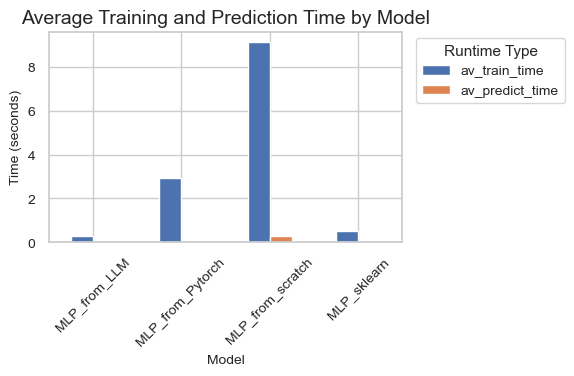

In [ ]:
runtime_df = df.groupby("model")[["av_train_time", "av_predict_time"]].mean().reset_index()
ax = runtime_df.plot(x='model', kind='bar', figsize=(6, 4))  # Larger plot

plt.title("Average Training and Prediction Time by Model", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=10)
plt.xlabel("Model", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Runtime Type", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=11)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

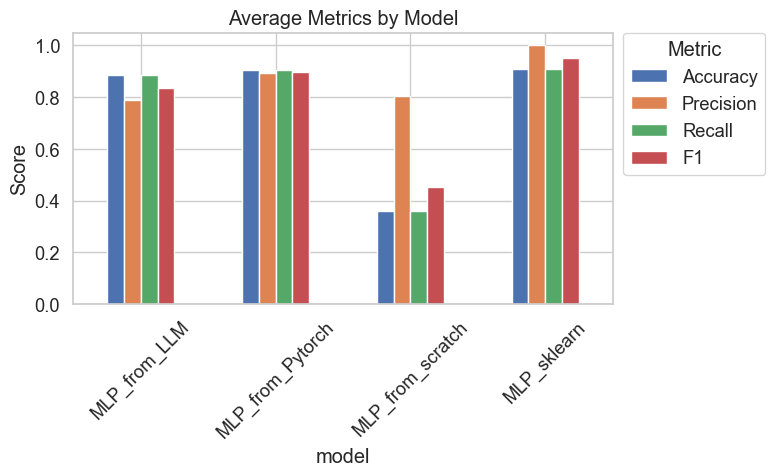

In [ ]:
# Group and calculate mean of selected metrics
metrics_df = df.groupby("model")[["accuracy_mean", "precision_mean", "recall_mean", "f1_mean"]].mean().reset_index()

metrics_df.rename(columns={
    "accuracy_mean": "Accuracy",
    "precision_mean": "Precision",
    "recall_mean": "Recall",
    "f1_mean": "F1"
}, inplace=True)

ax = metrics_df.set_index("model")[["Accuracy", "Precision", "Recall", "F1"]].plot(
    kind='bar',
    figsize=(8, 5)
)

plt.title("Average Metrics by Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

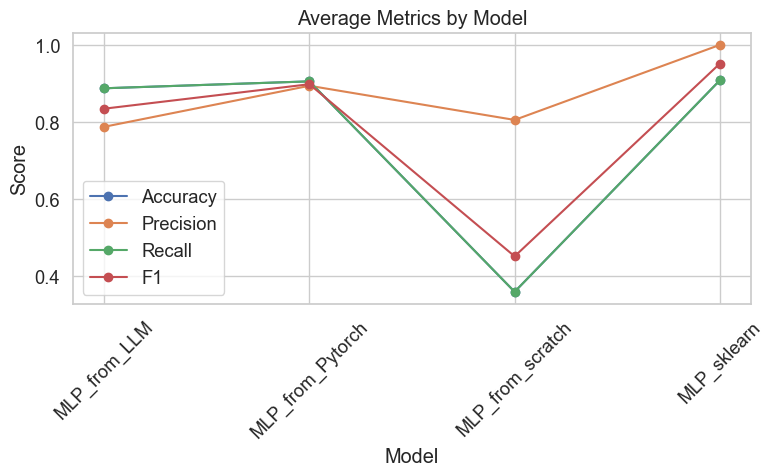

In [ ]:
# Group and rename metric columns
metrics_df = df.groupby("model")[["accuracy_mean", "precision_mean", "recall_mean", "f1_mean"]].mean().reset_index()
metrics_df.rename(columns={
    "accuracy_mean": "Accuracy",
    "precision_mean": "Precision",
    "recall_mean": "Recall",
    "f1_mean": "F1"
}, inplace=True)

plt.figure(figsize=(8, 5))
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    plt.plot(metrics_df["model"], metrics_df[metric], marker='o', label=metric)

plt.title("Average Metrics by Model")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

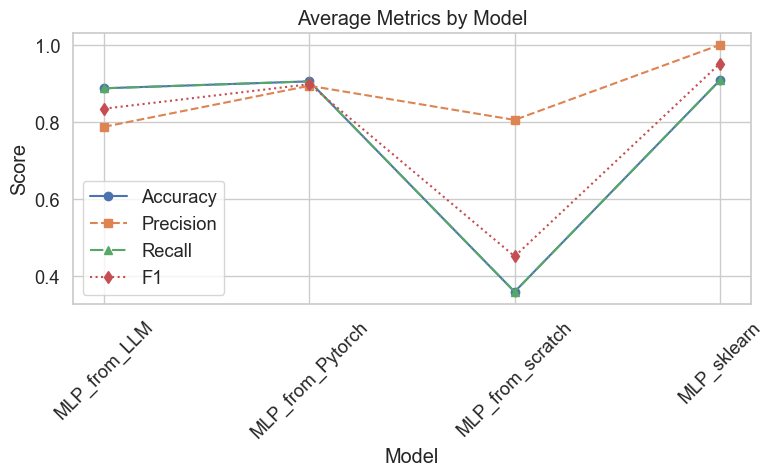

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["model"], metrics_df["Accuracy"], marker='o', label="Accuracy", linestyle='-')
plt.plot(metrics_df["model"], metrics_df["Precision"], marker='s', label="Precision", linestyle='--')
plt.plot(metrics_df["model"], metrics_df["Recall"], marker='^', label="Recall", linestyle='-.')
plt.plot(metrics_df["model"], metrics_df["F1"], marker='d', label="F1", linestyle=':')

plt.title("Average Metrics by Model")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

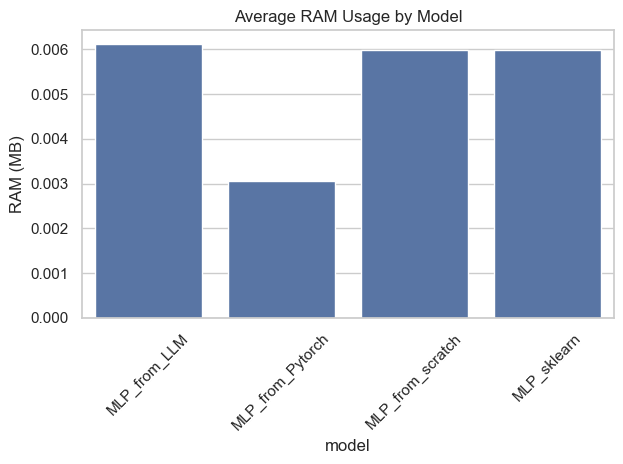

In [12]:
ram_df = df.groupby("model")["ram_mb"].mean().reset_index()

sns.barplot(data=ram_df, x="model", y="ram_mb")
plt.title("Average RAM Usage by Model")
plt.ylabel("RAM (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Select top N setups per model based on f1_mean
top_setups = df.sort_values(by='f1_mean', ascending=False).groupby('model').head(3)
top_setups[["model", "learning_rate", "hidden_layers", "activation", "batch_size", "f1_mean"]]

,model,learning_rate,hidden_layers,activation,batch_size,f1_mean
6,MLP_from_scratch,0.01,"[32, 16]",sigmoid,64.0,1.000000
7,MLP_from_scratch,0.05,"[32, 16]",sigmoid,64.0,0.998661
64,MLP_sklearn,0.05,[16],relu,64.0,0.982663
62,MLP_sklearn,0.10,[16],tanh,64.0,0.968936
58,MLP_sklearn,0.05,"[32, 16]",relu,64.0,0.959777
36,MLP_from_Pytorch,0.01,"[32, 16]",tanh,NaN,0.911199
42,MLP_from_Pytorch,0.01,"[32, 16]",sigmoid,NaN,0.910849
39,MLP_from_Pytorch,0.01,"[32, 16]",relu,NaN,0.909838
13,MLP_from_scratch,0.05,[16],relu,64.0,0.904686
35,MLP_from_LLM,0.10,[16],sigmoid,NaN,0.834685


In [17]:
# Select top N setups per model based on accuracy_mean
top_setups = df.sort_values(by='accuracy_mean', ascending=False).groupby('model').head(3)
top_setups[["model", "learning_rate", "hidden_layers", "activation", "batch_size", "accuracy_mean"]]

,model,learning_rate,hidden_layers,activation,batch_size,accuracy_mean
6,MLP_from_scratch,0.01,"[32, 16]",sigmoid,64.0,1.000000
7,MLP_from_scratch,0.05,"[32, 16]",sigmoid,64.0,0.997329
64,MLP_sklearn,0.05,[16],relu,64.0,0.965948
62,MLP_sklearn,0.10,[16],tanh,64.0,0.939909
58,MLP_sklearn,0.05,"[32, 16]",relu,64.0,0.924006
39,MLP_from_Pytorch,0.01,"[32, 16]",relu,NaN,0.913505
42,MLP_from_Pytorch,0.01,"[32, 16]",sigmoid,NaN,0.912989
45,MLP_from_Pytorch,0.01,[16],tanh,NaN,0.911684
34,MLP_from_LLM,0.05,[16],sigmoid,NaN,0.887557
35,MLP_from_LLM,0.10,[16],sigmoid,NaN,0.887557


#### Effect of Learning Rate on Accuracy (per model)

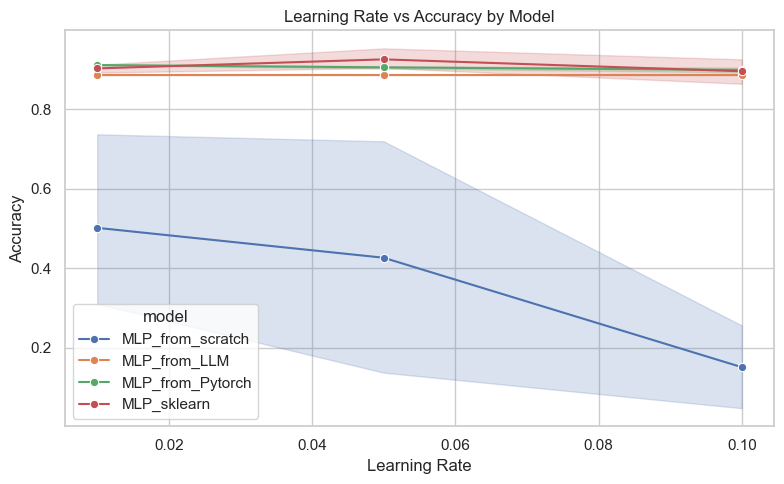

In [18]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x='learning_rate', y='accuracy_mean', hue='model', marker='o')
plt.title("Learning Rate vs Accuracy by Model")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

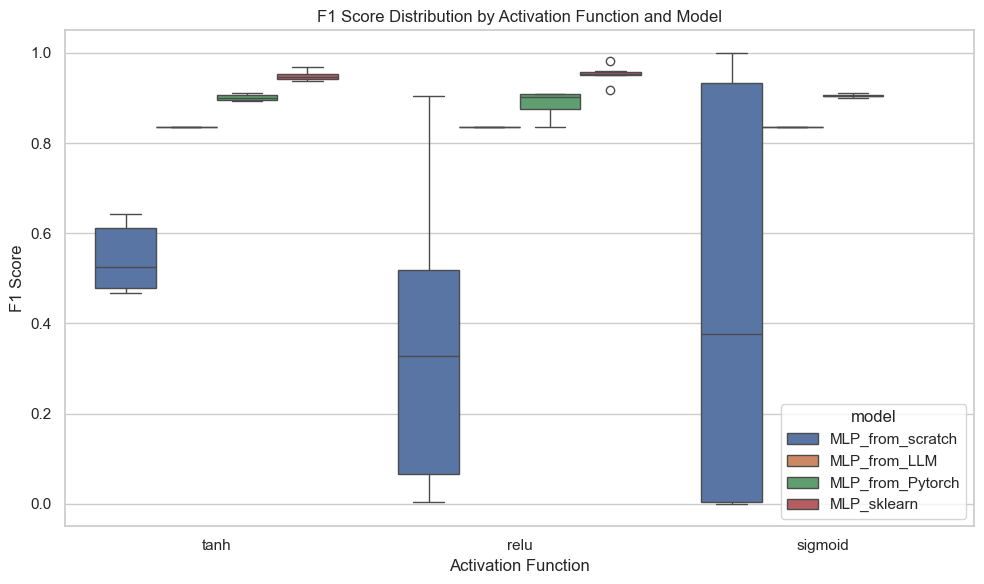

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='activation', y='f1_mean', hue='model')
plt.title("F1 Score Distribution by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

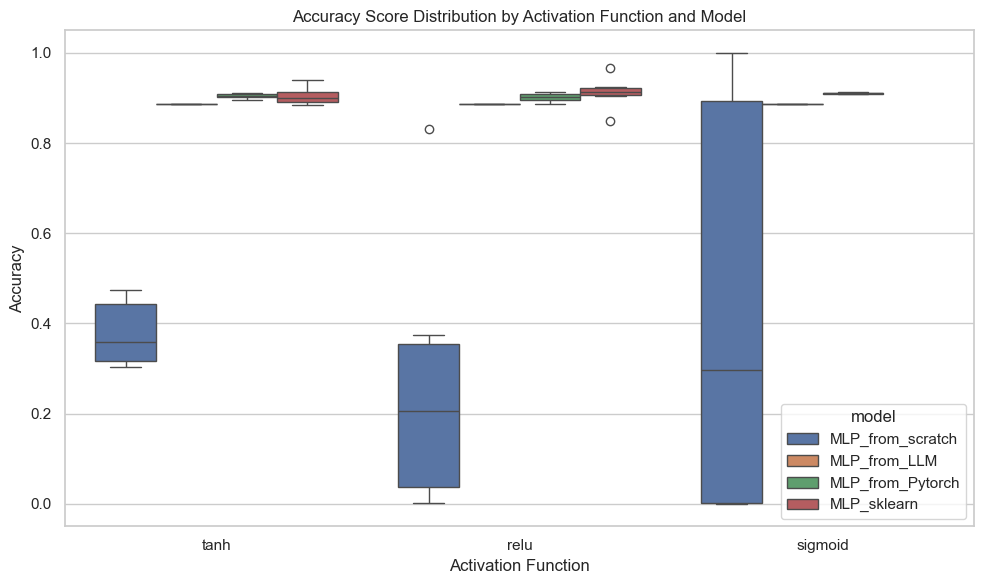

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='activation', y='accuracy_mean', hue='model')
plt.title("Accuracy Score Distribution by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

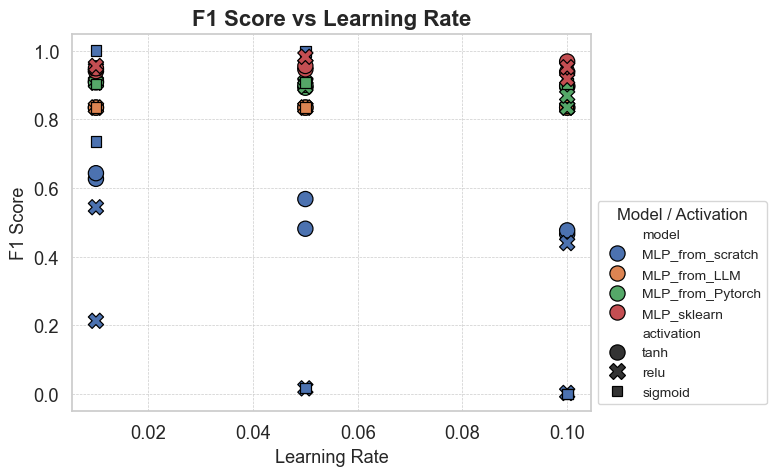

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8, 5))
plot = sns.scatterplot(
    data=df,
    x='learning_rate',
    y='f1_mean',
    hue='model',
    style='activation',
    s=120,  # marker size
    edgecolor='black',
    palette='deep'
)

plt.title("F1 Score vs Learning Rate", fontsize=16, weight='bold')
plt.xlabel("Learning Rate", fontsize=13)
plt.ylabel("F1 Score", fontsize=13)
plt.legend(title="Model / Activation", title_fontsize=12, fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

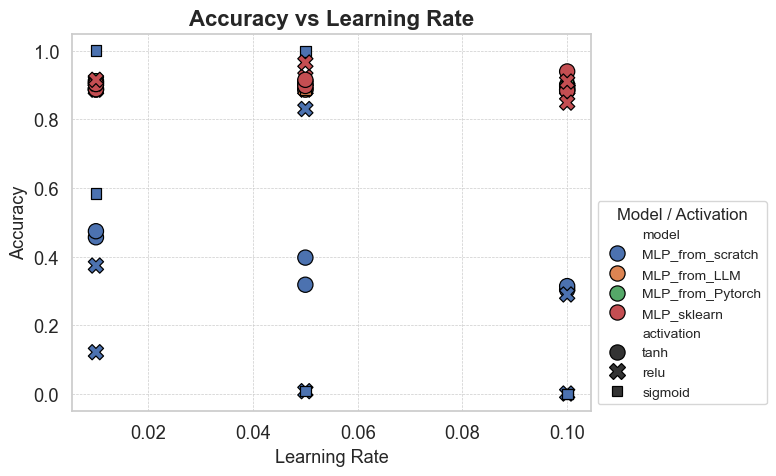

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))
plot = sns.scatterplot(
    data=df,
    x='learning_rate',
    y='accuracy_mean',
    hue='model',
    style='activation',
    s=120,  # marker size
    edgecolor='black',
    palette='deep'
)
plt.title("Accuracy vs Learning Rate", fontsize=16, weight='bold')
plt.xlabel("Learning Rate", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.legend(title="Model / Activation", title_fontsize=12, fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

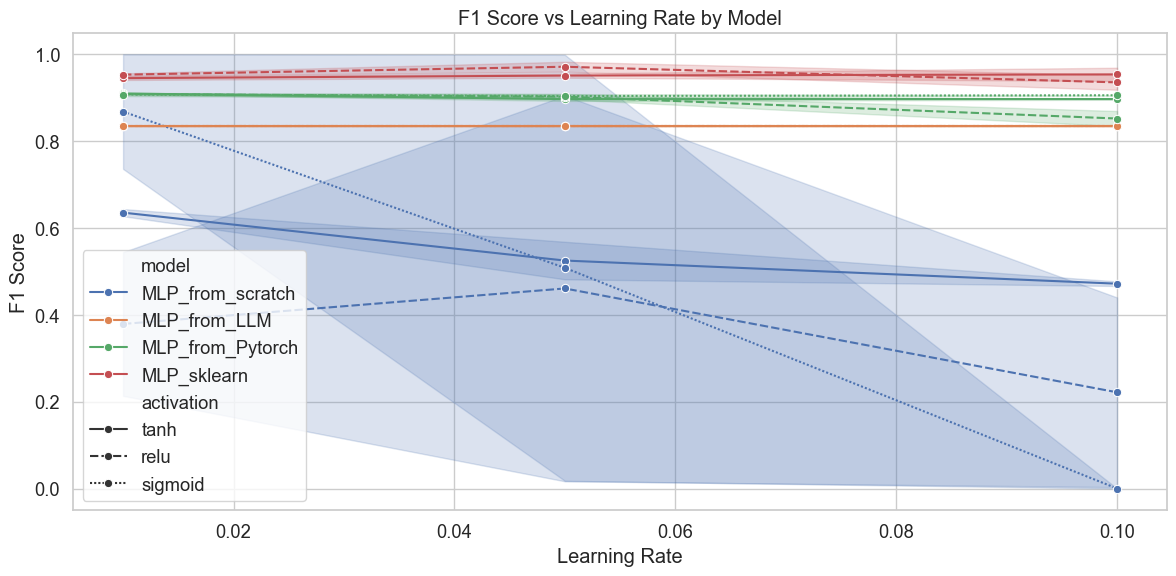

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="learning_rate", y="f1_mean", hue="model", marker="o", style="activation")
plt.title("F1 Score vs Learning Rate by Model")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

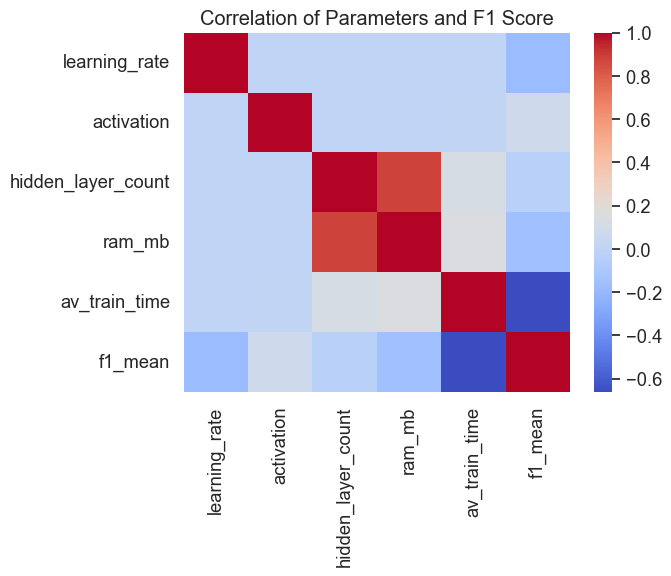

In [118]:
# Convert categorical variables
df_heat = df.copy()
df_heat["activation"] = df_heat["activation"].astype("category").cat.codes
df_heat["model"] = df_heat["model"].astype("category").cat.codes
df_heat["hidden_layer_count"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

corr_cols = ["learning_rate", "activation", "hidden_layer_count", "ram_mb", "av_train_time", "f1_mean"]
corr = df_heat[corr_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Parameters and F1 Score")
plt.tight_layout()
plt.show()

C:\Users\W11\AppData\Local\Temp\ipykernel_14216\3634241269.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="activation", y="f1_mean", hue="model", ci=None)


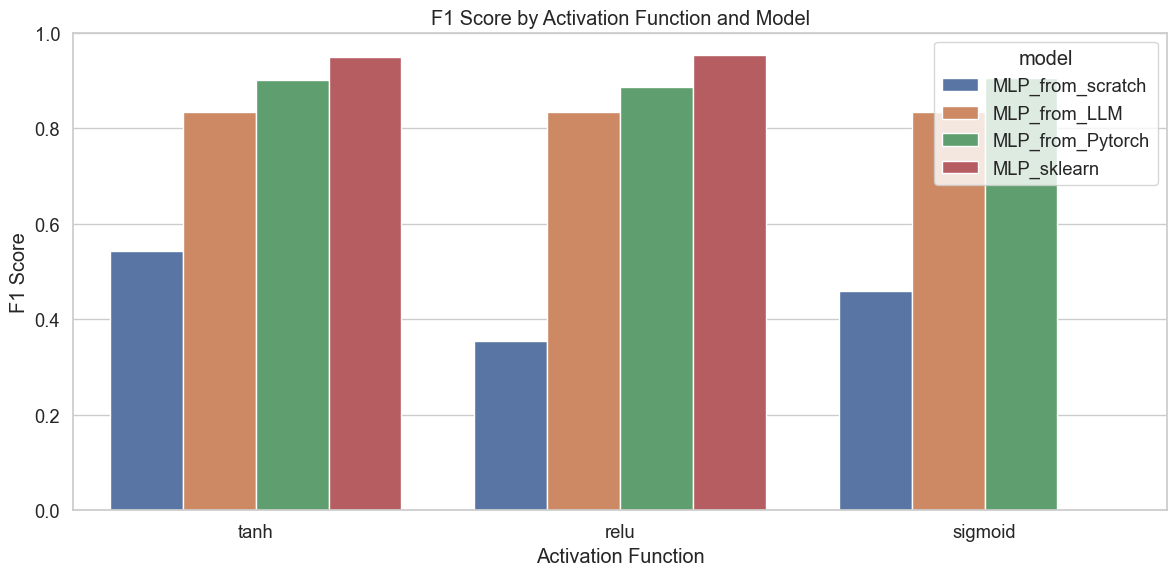

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="activation", y="f1_mean", hue="model", ci=None)
plt.title("F1 Score by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

C:\Users\W11\AppData\Local\Temp\ipykernel_14216\2465043555.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="activation", y="accuracy_mean", hue="model", ci=None)


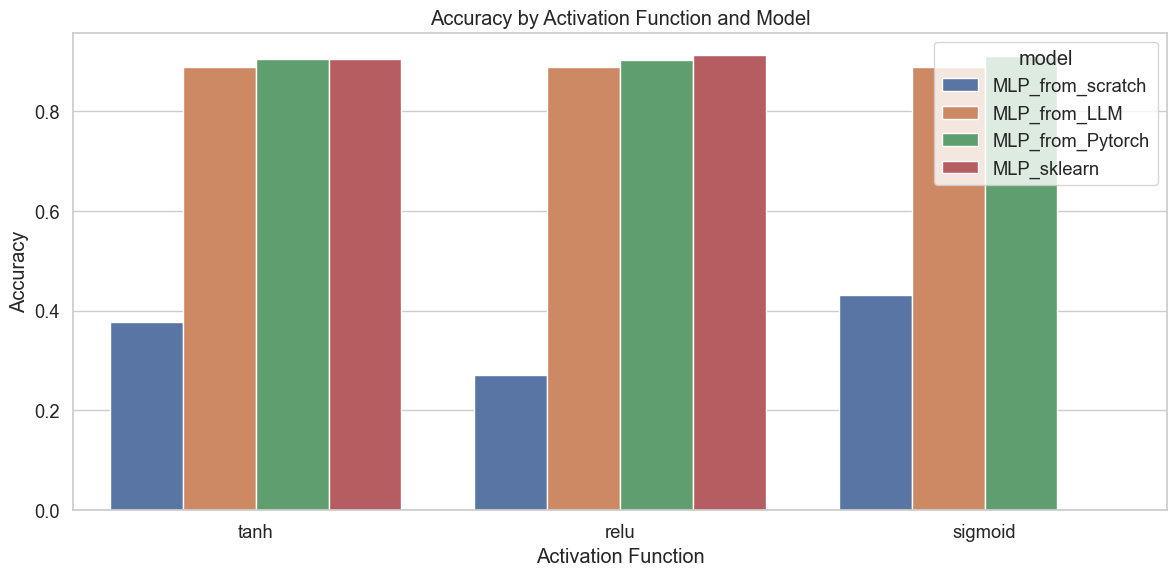

In [69]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="activation", y="accuracy_mean", hue="model", ci=None)
plt.title("Accuracy by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


C:\Users\W11\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


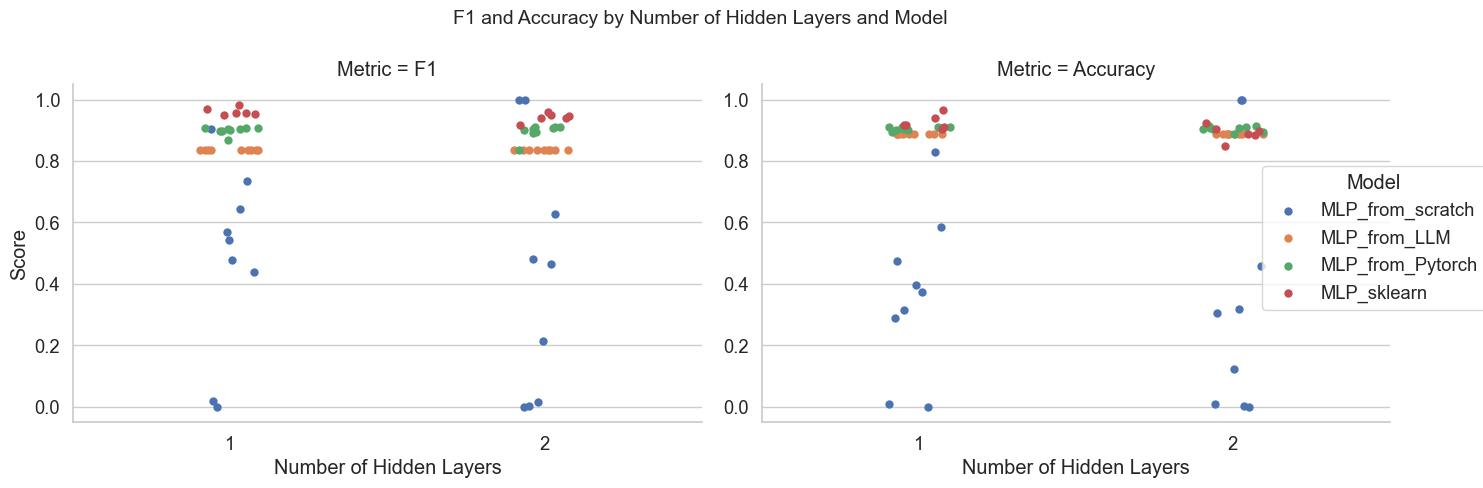

In [ ]:
df["hidden_layer_count"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
melted = pd.melt(
    df,
    id_vars=["hidden_layer_count", "model"],
    value_vars=["f1_mean", "accuracy_mean"],
    var_name="Metric",
    value_name="Score"
)

melted["Metric"] = melted["Metric"].replace({
    "f1_mean": "F1",
    "accuracy_mean": "Accuracy"
})

g = sns.FacetGrid(melted, col="Metric", hue="model", height=5, aspect=1.2, sharey=False)
g.map(sns.stripplot, "hidden_layer_count", "Score", dodge=True, jitter=True, size=6)

g.add_legend(title="Model")
g._legend.set_bbox_to_anchor((1.05, 0.5))  # move legend to the right
g._legend.set_frame_on(True)
g.set_axis_labels("Number of Hidden Layers", "Score")
g.fig.subplots_adjust(top=0.85, right=0.85)
g.fig.suptitle("F1 and Accuracy by Number of Hidden Layers and Model", fontsize=14)

plt.tight_layout()
plt.show()

C:\Users\W11\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


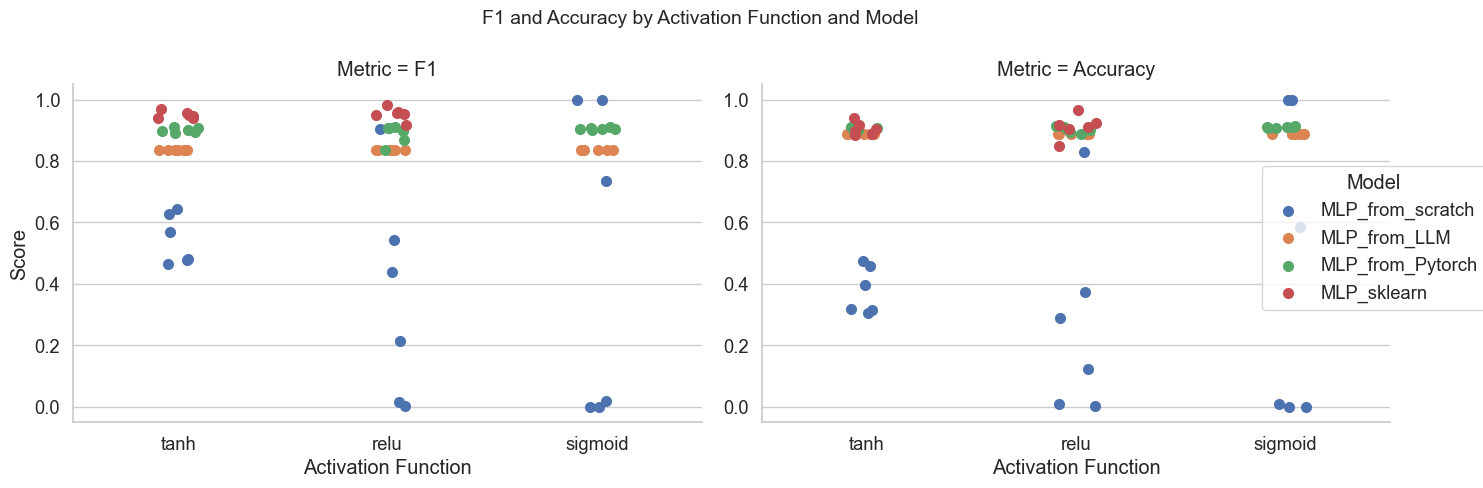

In [ ]:
melted = pd.melt(
    df,
    id_vars=["activation", "model"],
    value_vars=["f1_mean", "accuracy_mean"],
    var_name="Metric",
    value_name="Score"
)

melted["Metric"] = melted["Metric"].replace({
    "f1_mean": "F1",
    "accuracy_mean": "Accuracy"
})

g = sns.FacetGrid(
    melted,
    col="Metric",
    hue="model",
    height=5,
    aspect=1.2,
    sharey=False
)

g.map(sns.stripplot, "activation", "Score", dodge=True, jitter=True, size=8)

g.add_legend(title="Model")
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_frame_on(True)
g.set_axis_labels("Activation Function", "Score")
g.fig.subplots_adjust(top=0.85, right=0.85)
g.fig.suptitle("F1 and Accuracy by Activation Function and Model", fontsize=14)
plt.tight_layout()
plt.show()

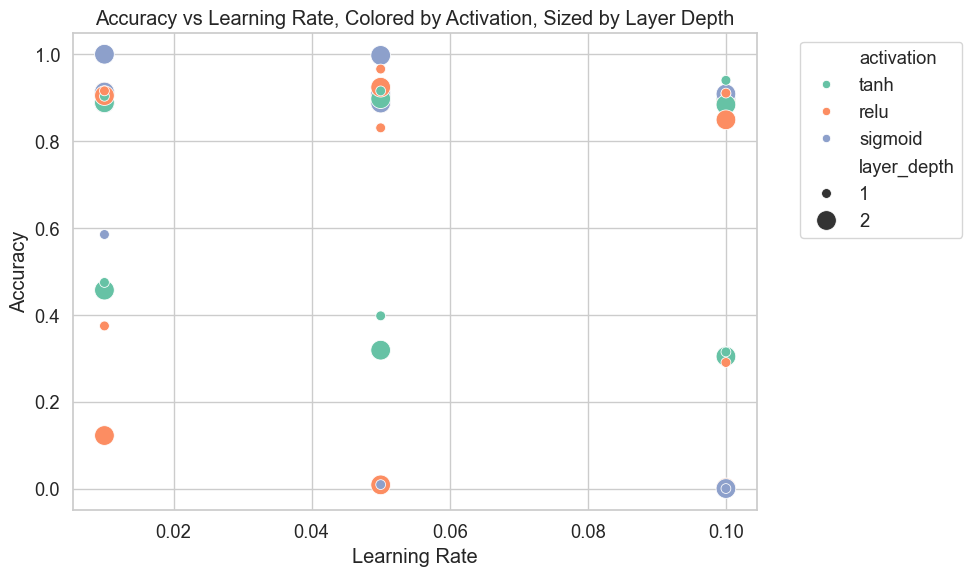

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="accuracy_mean",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)

plt.title("Accuracy vs Learning Rate, Colored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

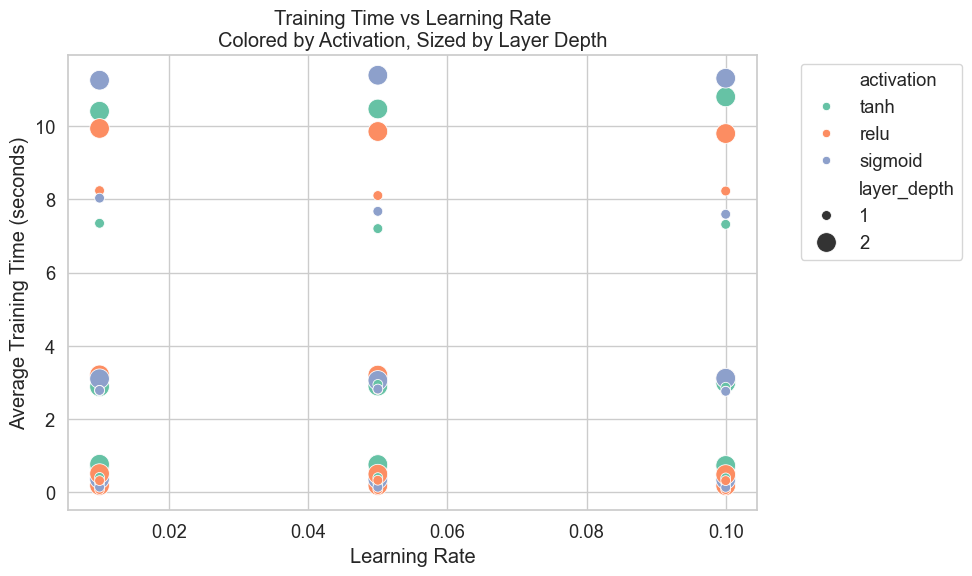

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="av_train_time",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)

plt.title("Training Time vs Learning Rate\nColored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("Average Training Time (seconds)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

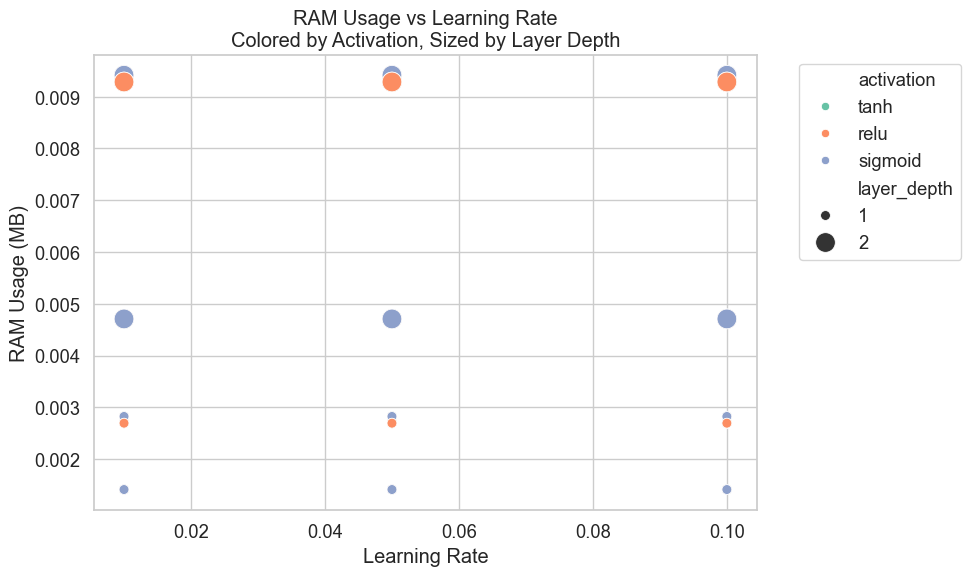

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="ram_mb",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)

plt.title("RAM Usage vs Learning Rate\nColored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("RAM Usage (MB)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4.2. Visualization of Amazon Dataset

In [ ]:
df = pd.read_csv("./model_results/amazon_reviews_res.csv") 
grouped = df.groupby("model")

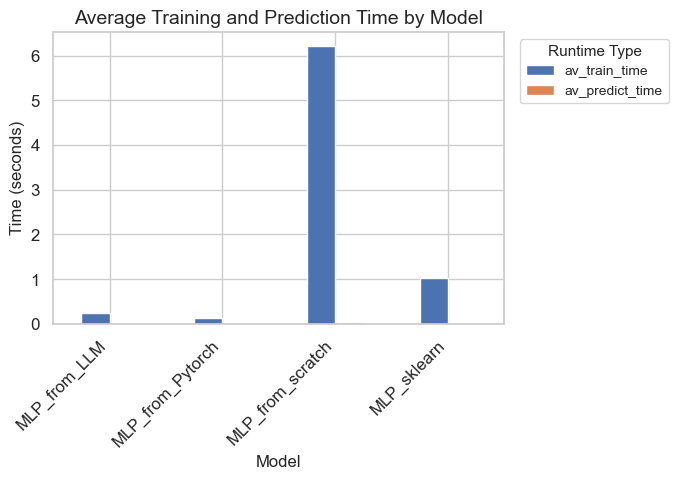

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.1)

runtime_df = df.groupby("model")[["av_train_time", "av_predict_time"]].mean().reset_index()
ax = runtime_df.plot(
    x='model',
    kind='bar',
    figsize=(7, 5)
)

plt.title("Average Training and Prediction Time by Model", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Runtime Type", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

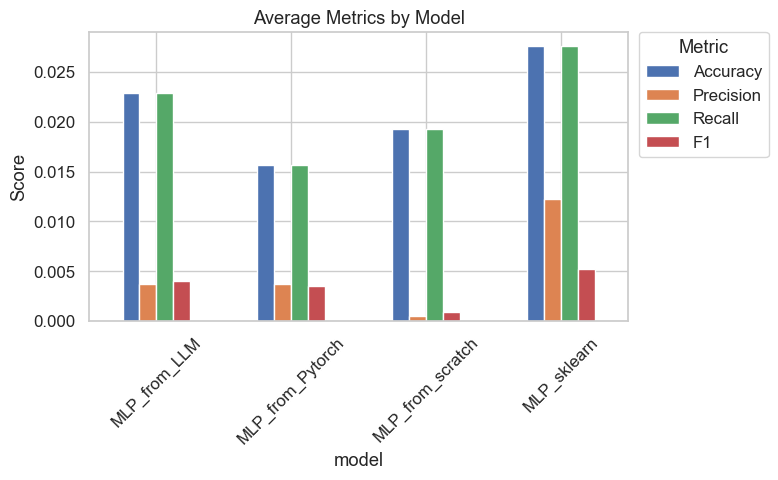

In [ ]:
metrics_df = df.groupby("model")[["accuracy_mean", "precision_mean", "recall_mean", "f1_mean"]].mean().reset_index()

metrics_df.rename(columns={
    "accuracy_mean": "Accuracy",
    "precision_mean": "Precision",
    "recall_mean": "Recall",
    "f1_mean": "F1"
}, inplace=True)

ax = metrics_df.set_index("model")[["Accuracy", "Precision", "Recall", "F1"]].plot(
    kind='bar',
    figsize=(8, 5)
)

plt.title("Average Metrics by Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

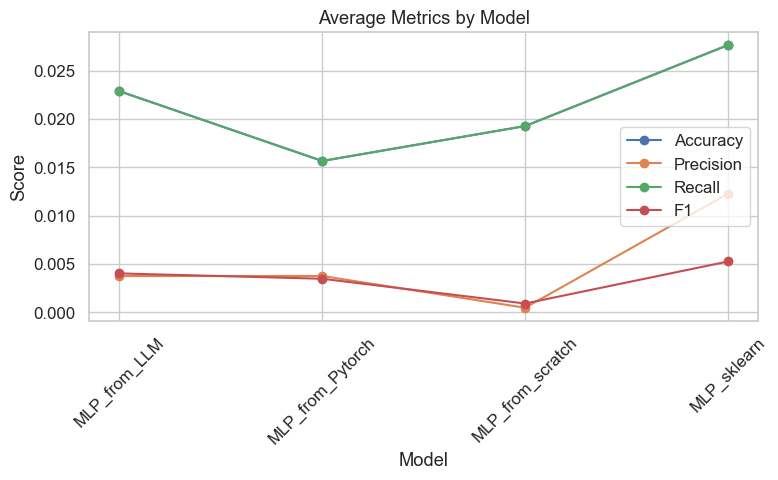

In [ ]:
metrics_df = df.groupby("model")[["accuracy_mean", "precision_mean", "recall_mean", "f1_mean"]].mean().reset_index()
metrics_df.rename(columns={
    "accuracy_mean": "Accuracy",
    "precision_mean": "Precision",
    "recall_mean": "Recall",
    "f1_mean": "F1"
}, inplace=True)

plt.figure(figsize=(8, 5))
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    plt.plot(metrics_df["model"], metrics_df[metric], marker='o', label=metric)

plt.title("Average Metrics by Model")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

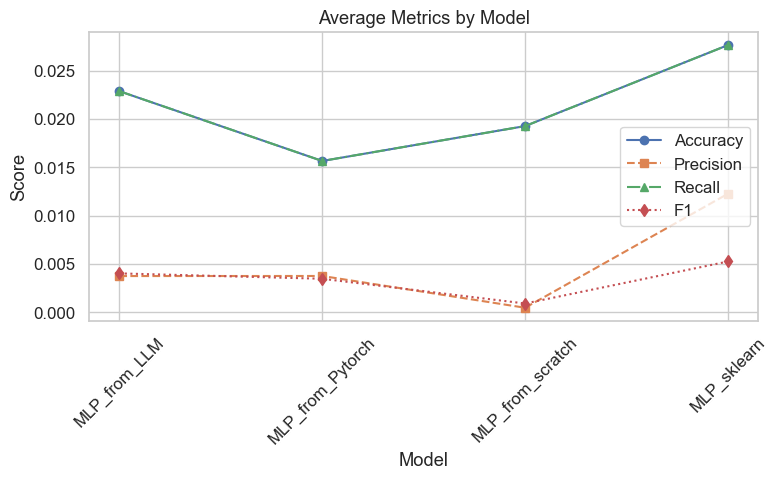

In [89]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["model"], metrics_df["Accuracy"], marker='o', label="Accuracy", linestyle='-')
plt.plot(metrics_df["model"], metrics_df["Precision"], marker='s', label="Precision", linestyle='--')
plt.plot(metrics_df["model"], metrics_df["Recall"], marker='^', label="Recall", linestyle='-.')
plt.plot(metrics_df["model"], metrics_df["F1"], marker='d', label="F1", linestyle=':')
plt.title("Average Metrics by Model")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

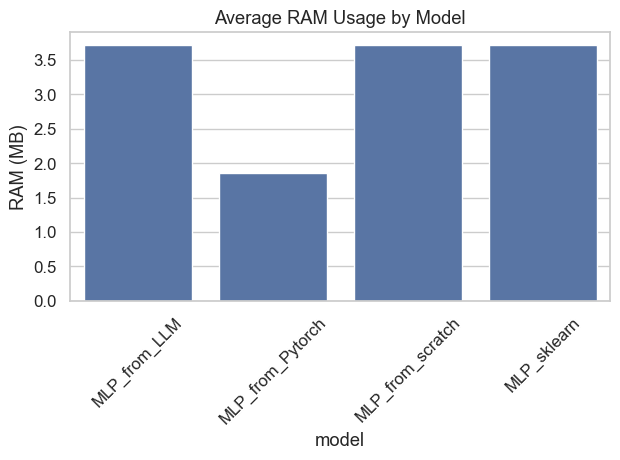

In [90]:
ram_df = df.groupby("model")["ram_mb"].mean().reset_index()
sns.barplot(data=ram_df, x="model", y="ram_mb")
plt.title("Average RAM Usage by Model")
plt.ylabel("RAM (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [91]:
# Select top N setups per model based on f1_mean
top_setups = df.sort_values(by='f1_mean', ascending=False).groupby('model').head(3)
top_setups[["model", "learning_rate", "hidden_layers", "activation", "batch_size", "f1_mean"]]

,model,learning_rate,hidden_layers,activation,batch_size,f1_mean
63,MLP_sklearn,0.01,[64],relu,64.0,0.041336
48,MLP_from_Pytorch,0.01,[64],relu,NaN,0.030430
27,MLP_from_LLM,0.01,[64],tanh,NaN,0.011707
57,MLP_sklearn,0.01,"[128, 64]",relu,64.0,0.009417
39,MLP_from_Pytorch,0.01,"[128, 64]",relu,NaN,0.008921
33,MLP_from_LLM,0.01,[64],sigmoid,NaN,0.008551
30,MLP_from_LLM,0.01,[64],relu,NaN,0.007367
47,MLP_from_Pytorch,0.10,[64],tanh,NaN,0.006174
14,MLP_from_scratch,0.10,[64],relu,64.0,0.001341
4,MLP_from_scratch,0.05,"[128, 64]",relu,64.0,0.001341


In [92]:
# Select top N setups per model based on accuracy_mean
top_setups = df.sort_values(by='accuracy_mean', ascending=False).groupby('model').head(3)
top_setups[["model", "learning_rate", "hidden_layers", "activation", "batch_size", "accuracy_mean"]]

,model,learning_rate,hidden_layers,activation,batch_size,accuracy_mean
48,MLP_from_Pytorch,0.01,[64],relu,NaN,0.061667
63,MLP_sklearn,0.01,[64],relu,64.0,0.051667
39,MLP_from_Pytorch,0.01,"[128, 64]",relu,NaN,0.040000
27,MLP_from_LLM,0.01,[64],tanh,NaN,0.035000
30,MLP_from_LLM,0.01,[64],relu,NaN,0.035000
33,MLP_from_LLM,0.01,[64],sigmoid,NaN,0.031667
57,MLP_sklearn,0.01,"[128, 64]",relu,64.0,0.030000
55,MLP_sklearn,0.05,"[128, 64]",tanh,64.0,0.025000
0,MLP_from_scratch,0.01,"[128, 64]",tanh,64.0,0.025000
3,MLP_from_scratch,0.01,"[128, 64]",relu,64.0,0.025000


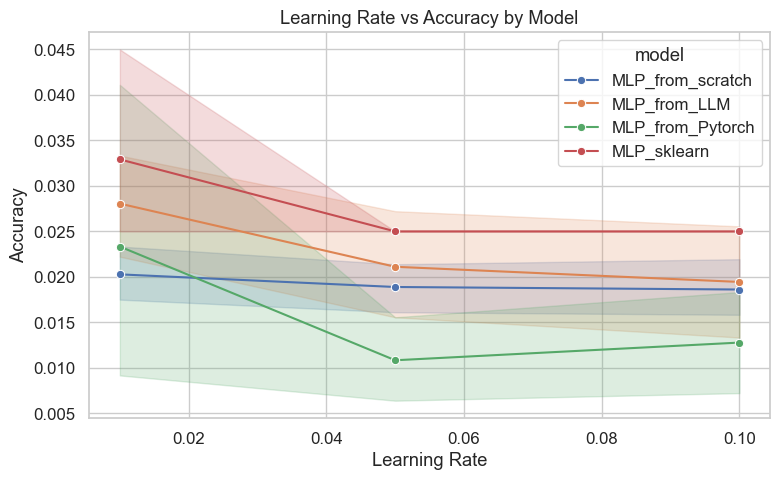

In [93]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x='learning_rate', y='accuracy_mean', hue='model', marker='o')
plt.title("Learning Rate vs Accuracy by Model")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

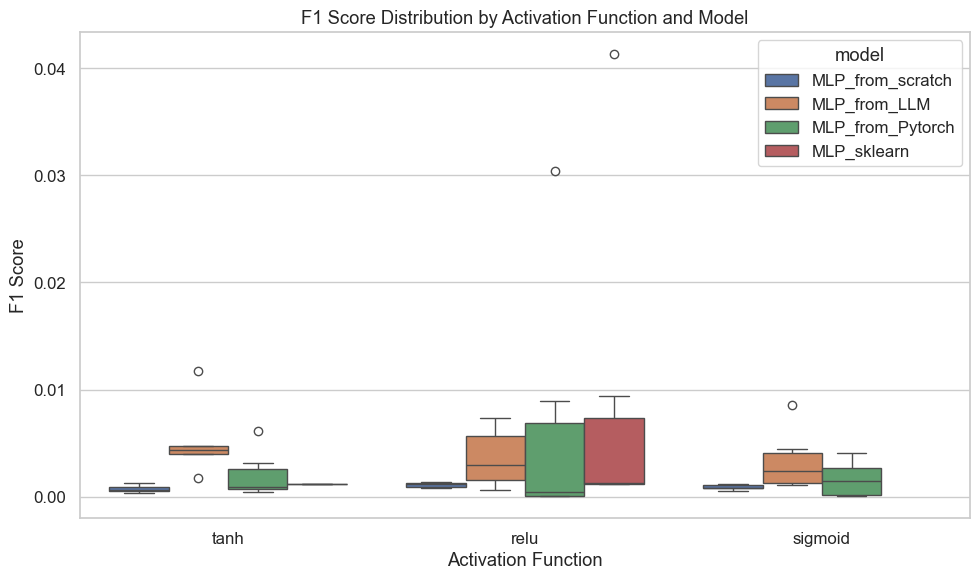

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='activation', y='f1_mean', hue='model')
plt.title("F1 Score Distribution by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

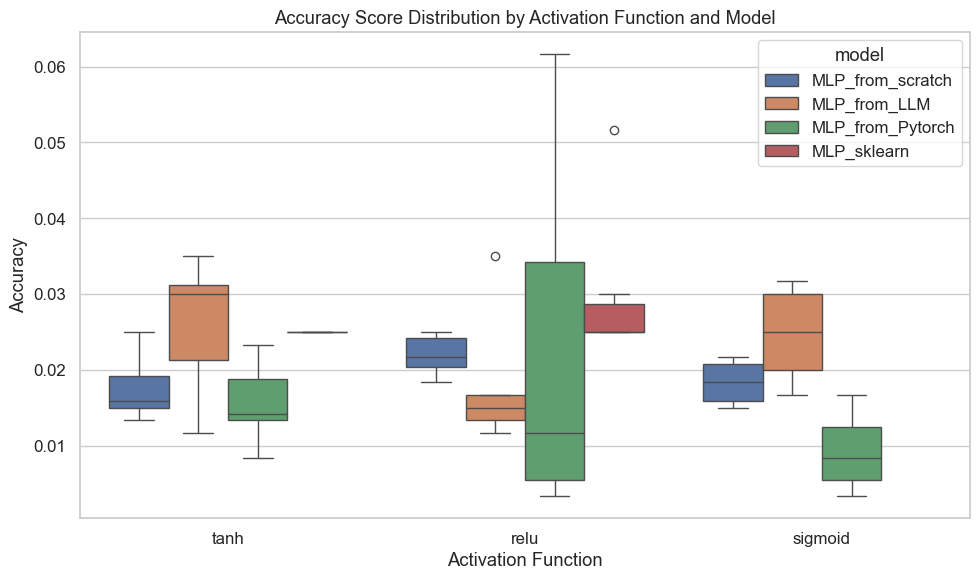

In [95]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='activation', y='accuracy_mean', hue='model')
plt.title("Accuracy Score Distribution by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

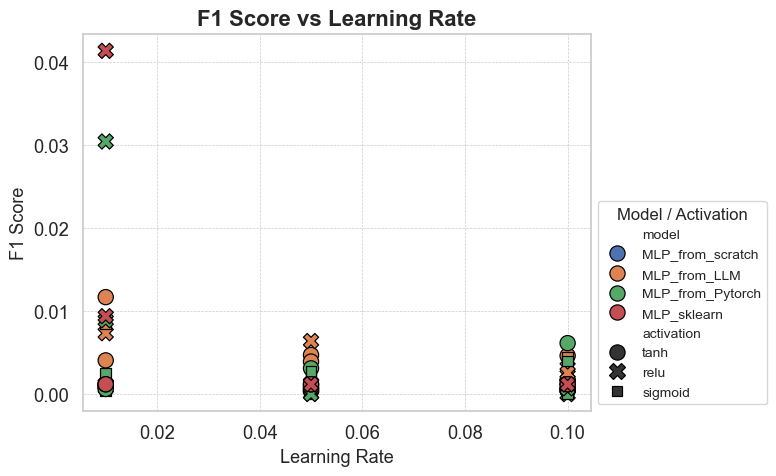

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8, 5))
plot = sns.scatterplot(
    data=df,
    x='learning_rate',
    y='f1_mean',
    hue='model',
    style='activation',
    s=120,  # marker size
    edgecolor='black',
    palette='deep'
)

plt.title("F1 Score vs Learning Rate", fontsize=16, weight='bold')
plt.xlabel("Learning Rate", fontsize=13)
plt.ylabel("F1 Score", fontsize=13)
plt.legend(title="Model / Activation", title_fontsize=12, fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

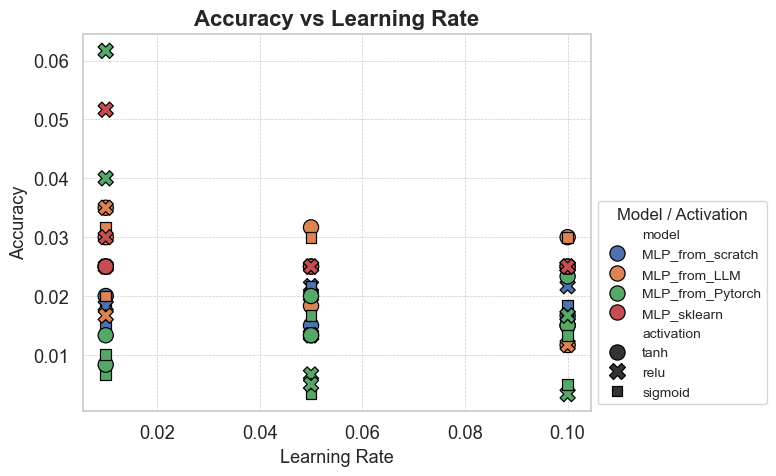

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8, 5))
plot = sns.scatterplot(
    data=df,
    x='learning_rate',
    y='accuracy_mean',
    hue='model',
    style='activation',
    s=120,  # marker size
    edgecolor='black',
    palette='deep'
)

plt.title("Accuracy vs Learning Rate", fontsize=16, weight='bold')
plt.xlabel("Learning Rate", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.legend(title="Model / Activation", title_fontsize=12, fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

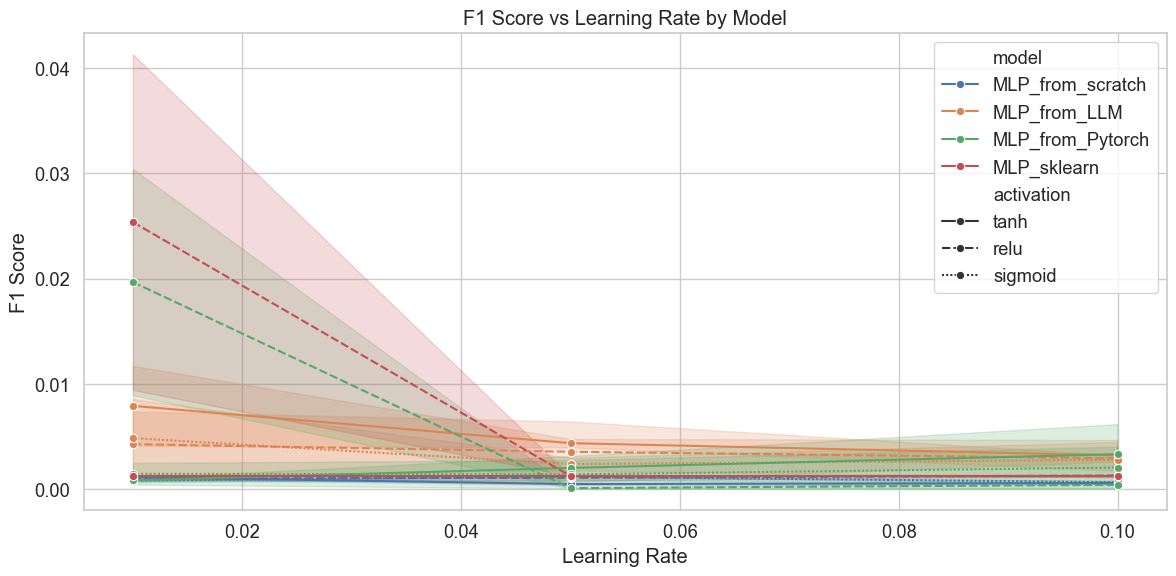

In [98]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="learning_rate", y="f1_mean", hue="model", marker="o", style="activation")
plt.title("F1 Score vs Learning Rate by Model")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

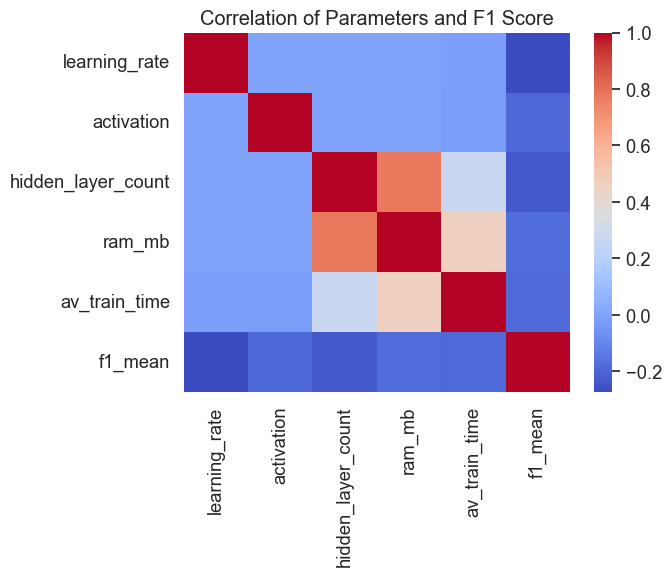

In [120]:
# Convert categorical variables
df_heat = df.copy()
df_heat["activation"] = df_heat["activation"].astype("category").cat.codes
df_heat["model"] = df_heat["model"].astype("category").cat.codes
df_heat["hidden_layer_count"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
corr_cols = ["learning_rate", "activation", "hidden_layer_count", "ram_mb", "av_train_time", "f1_mean"]
corr = df_heat[corr_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Parameters and F1 Score")
plt.tight_layout()
plt.show()

C:\Users\W11\AppData\Local\Temp\ipykernel_14216\3634241269.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="activation", y="f1_mean", hue="model", ci=None)


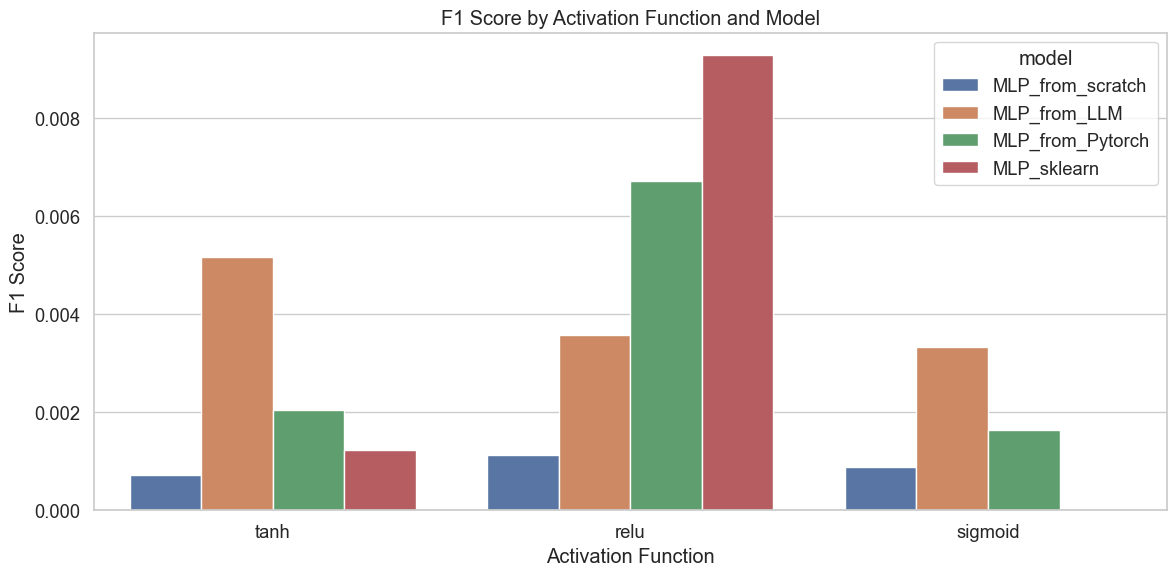

In [100]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="activation", y="f1_mean", hue="model", ci=None)
plt.title("F1 Score by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

C:\Users\W11\AppData\Local\Temp\ipykernel_14216\2465043555.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="activation", y="accuracy_mean", hue="model", ci=None)


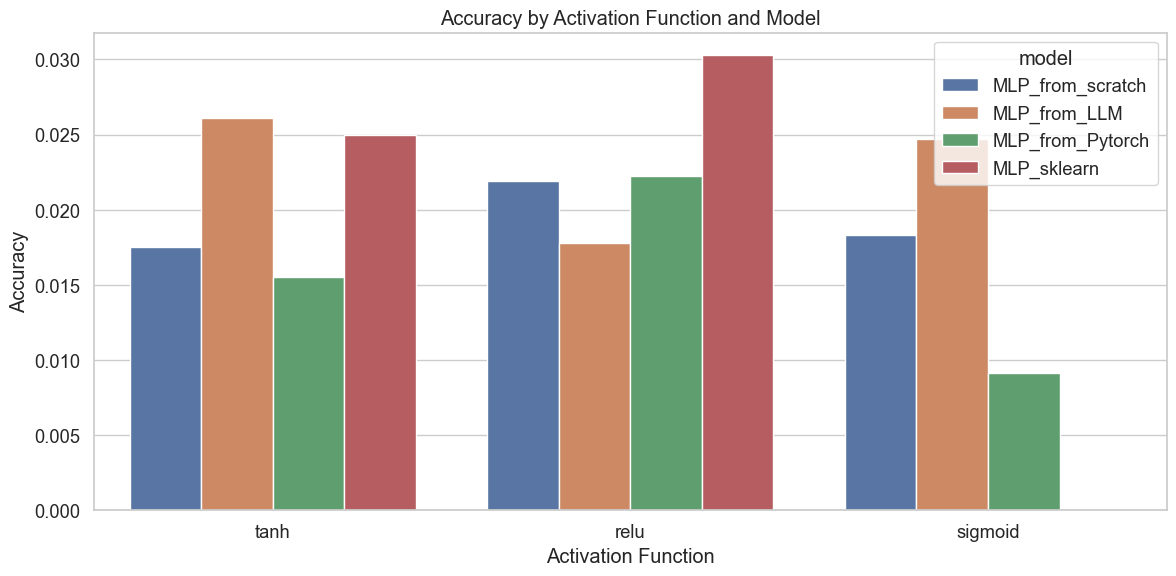

In [101]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="activation", y="accuracy_mean", hue="model", ci=None)
plt.title("Accuracy by Activation Function and Model")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

C:\Users\W11\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


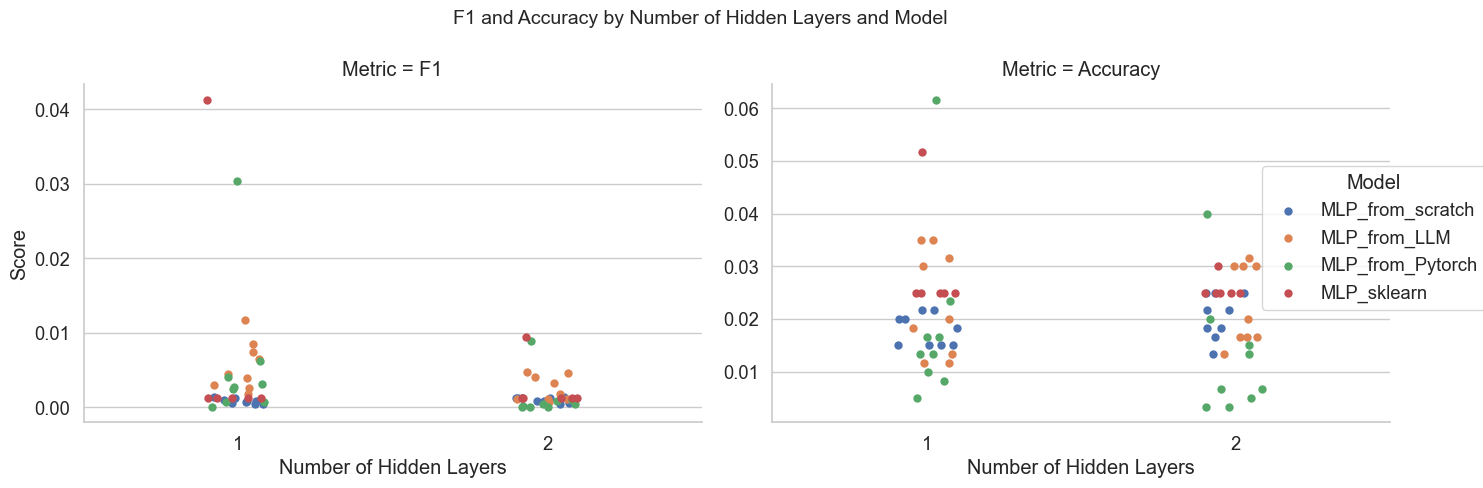

In [ ]:
df["hidden_layer_count"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
melted = pd.melt(
    df,
    id_vars=["hidden_layer_count", "model"],
    value_vars=["f1_mean", "accuracy_mean"],
    var_name="Metric",
    value_name="Score"
)

melted["Metric"] = melted["Metric"].replace({
    "f1_mean": "F1",
    "accuracy_mean": "Accuracy"
})

g = sns.FacetGrid(melted, col="Metric", hue="model", height=5, aspect=1.2, sharey=False)
g.map(sns.stripplot, "hidden_layer_count", "Score", dodge=True, jitter=True, size=6)
g.add_legend(title="Model")
g._legend.set_bbox_to_anchor((1.05, 0.5))  # move legend to the right
g._legend.set_frame_on(True)
g.set_axis_labels("Number of Hidden Layers", "Score")
g.fig.subplots_adjust(top=0.85, right=0.85)
g.fig.suptitle("F1 and Accuracy by Number of Hidden Layers and Model", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\W11\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


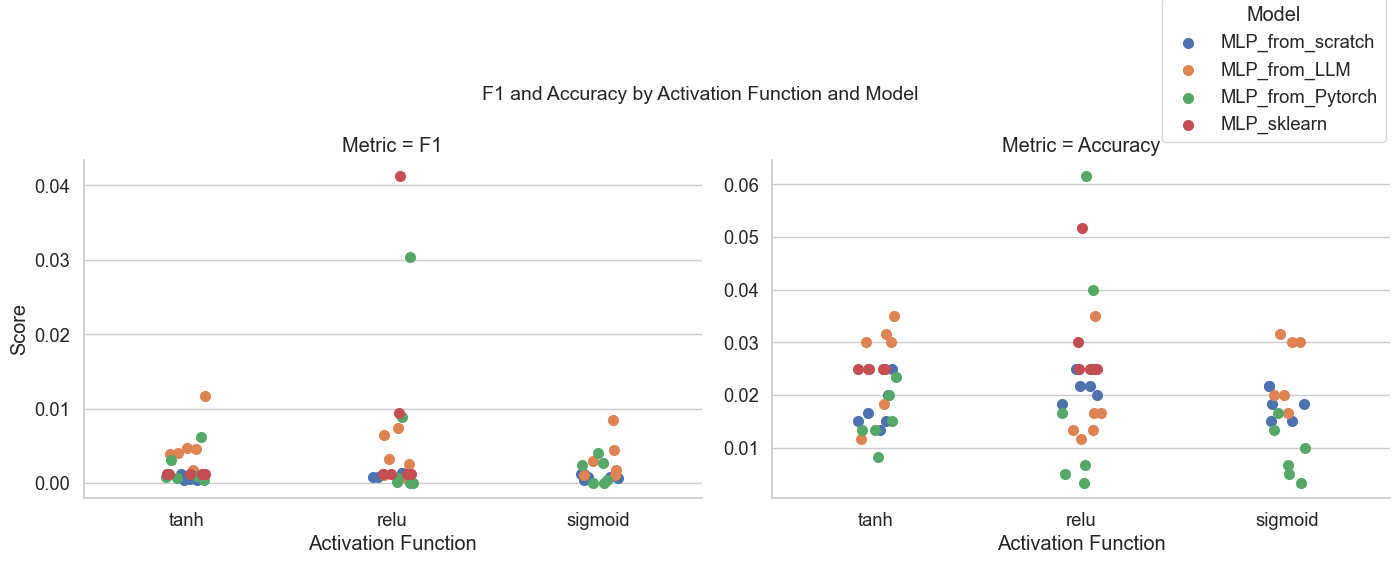

In [ ]:
melted = pd.melt(
    df,
    id_vars=["activation", "model"],
    value_vars=["f1_mean", "accuracy_mean"],
    var_name="Metric",
    value_name="Score"
)
melted["Metric"] = melted["Metric"].replace({
    "f1_mean": "F1",
    "accuracy_mean": "Accuracy"
})

g = sns.FacetGrid(
    melted,
    col="Metric",
    hue="model",
    height=5,
    aspect=1.2,
    sharey=False
)

g.map(sns.stripplot, "activation", "Score", dodge=True, jitter=True, size=8)
g.add_legend(title="Model")
g._legend.set_bbox_to_anchor((0.98, 1.15))  # Move it above the top-right plot
g._legend.set_loc("upper right")            # Align to upper right
g._legend.set_frame_on(True)
g.set_axis_labels("Activation Function", "Score")
g.fig.subplots_adjust(top=0.82, right=0.85)
g.fig.suptitle("F1 and Accuracy by Activation Function and Model", fontsize=14)
plt.tight_layout()
plt.show()

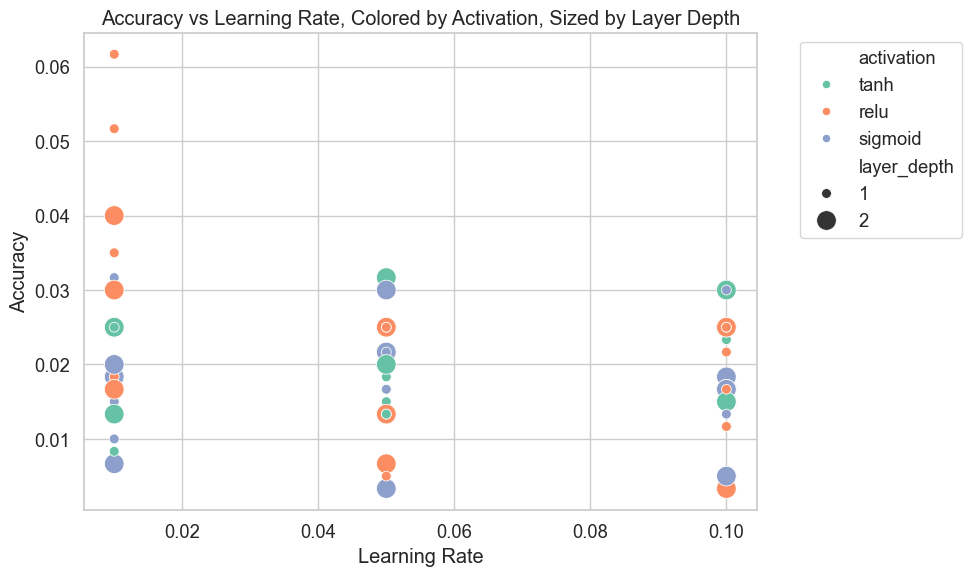

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="accuracy_mean",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)

plt.title("Accuracy vs Learning Rate, Colored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

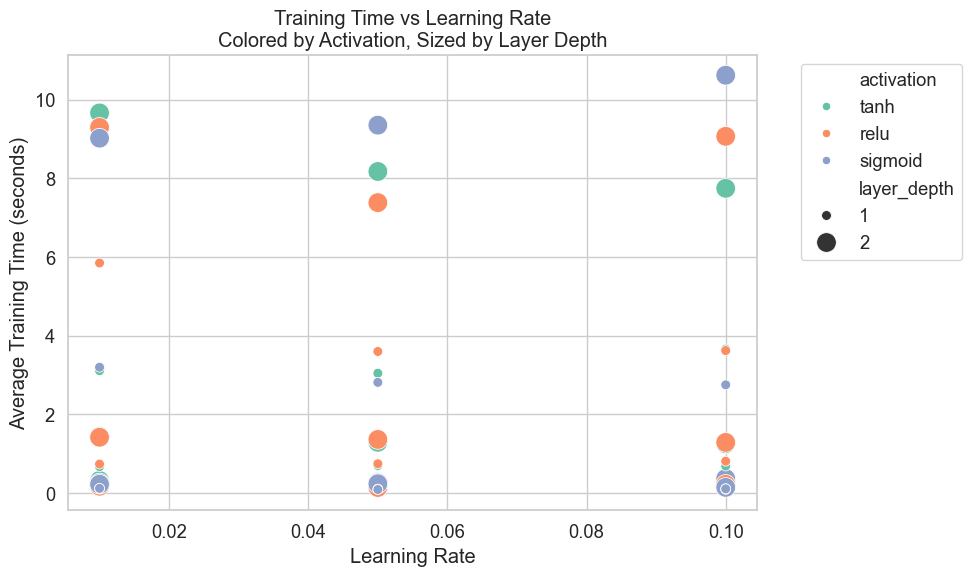

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="av_train_time",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)

plt.title("Training Time vs Learning Rate\nColored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("Average Training Time (seconds)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

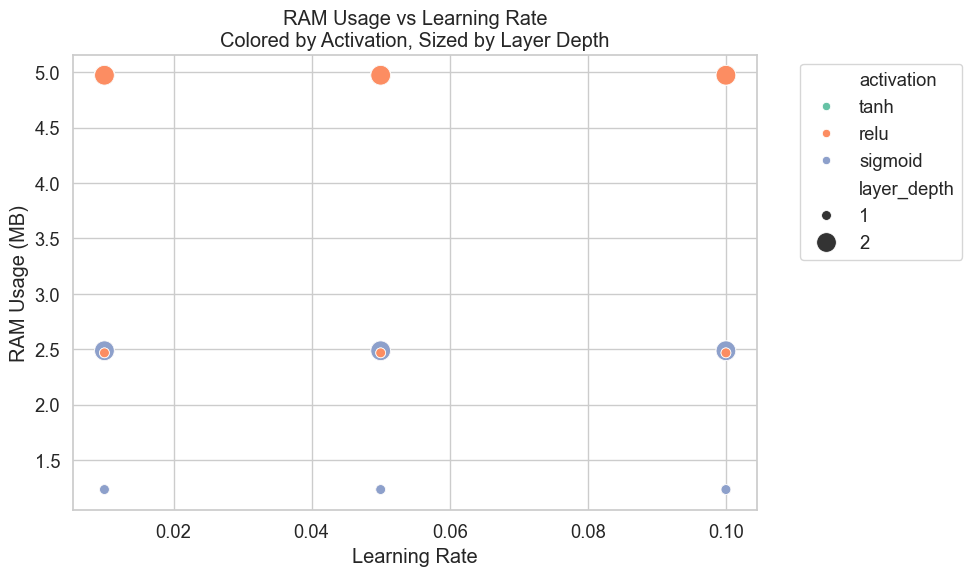

In [ ]:
df["layer_depth"] = df["hidden_layers"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="learning_rate",
    y="ram_mb",
    hue="activation",
    size="layer_depth",
    sizes=(50, 200),
    palette="Set2"
)
plt.title("RAM Usage vs Learning Rate\nColored by Activation, Sized by Layer Depth")
plt.xlabel("Learning Rate")
plt.ylabel("RAM Usage (MB)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()